<a href="https://colab.research.google.com/github/Faskill/MLOps-Text-Classification/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying MLOPS principles to develop a Text Classification Model

Last updated : 6th January 2023

## Introduction

The goal of this project is to develop a Project Classification Model using production grade MLOPS practices. 

In this notebook, I will develop a supervised machine learning (classification) model using a simple vectorization algorithm (TF-IDF).

This model could be improved by using BERT Embeddings and a higher-end deep learning model.

After developing this baseline model, I will optimize it using experiment tracking modules before switching to Python scripts for the development and deployment of more advanced alternatives.


## 1 Data Loading and Analysis

### 1.1 ETL

In [ ]:
import pandas as pd
# Loading projects"
projects = pd.read_csv("https://raw.githubusercontent.com/Faskill/MLOps-Text-Classification/main/Data/projects.csv")
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [ ]:
# Loading tags
tags = pd.read_csv("https://raw.githubusercontent.com/Faskill/MLOps-Text-Classification/main/Data/tags.csv")
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [ ]:
# Merging projects and tags
df = pd.merge(projects, tags, on="id", how = "outer")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [ ]:
# Removing projects without a tag
df = df[df.tag.notnull()]
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [ ]:
# Saving data locally
df.to_csv("labeled_projects.csv", index=False)

### 1.2 Exploratory Data Analysis (EDA)

In [ ]:
# Counting the number of tags of each category
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
mlops                           79
reinforcement-learning          56
graph-learning                  45
time-series                     31
Name: tag, dtype: int64

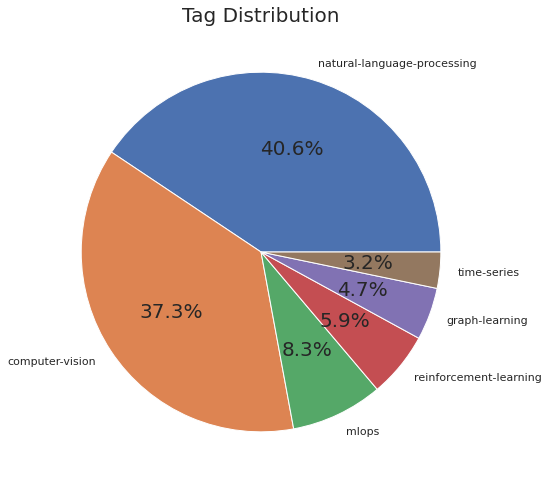

In [ ]:
#Creating a pie chart of the tags
import matplotlib.pyplot as plt
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

vc = df.tag.value_counts()
plt.pie(vc, labels = vc.index,autopct='%1.1f%%')
plt.title('Tag Distribution')
plt.show()

In [ ]:
# Calculating title and description length
df['title_length'] = df['title'].apply(len)
df['desc_length'] = df['description'].apply(len)

df.head()

,id,created_on,title,description,tag,title_length,desc_length
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89


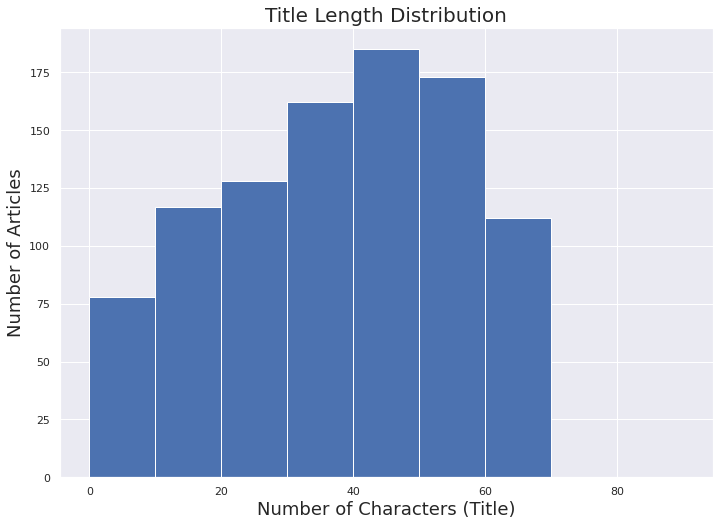

In [ ]:
#Histogram of title length
plt.hist(df['title_length'], bins = range(0,100,10))
plt.title('Title Length Distribution')
plt.xlabel('Number of Characters (Title)')
plt.ylabel('Number of Articles')
plt.show()

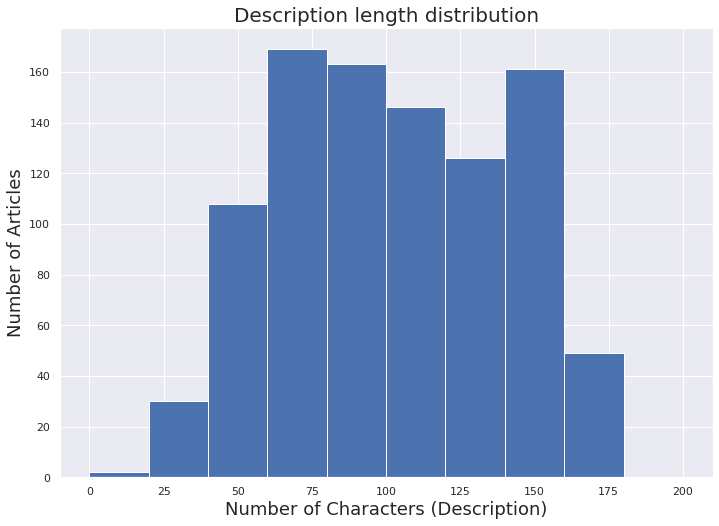

In [ ]:
#Histogram of description length
plt.hist(df['desc_length'], bins = range(0,220,20))
plt.title('Description length distribution')
plt.xlabel('Number of Characters (Description)')
plt.ylabel('Number of Articles')
plt.show()

In [ ]:
#Let's investigate the outliers with a description below 25 characters
df[df.desc_length < 25]

,id,created_on,title,description,tag,title_length,desc_length
29,108,2020-03-21 23:17:38,Tuned ALBERT (ensemble model),Top 6 in Squad 2.0,natural-language-processing,29,18
341,880,2020-05-16 11:50:31,How Deep Is Your Love For Transfer Learning In...,A review of NLP research,natural-language-processing,51,24
536,1480,2020-06-16 23:06:13,A Guide to Natural Language Processing With Al...,basics of using AllenNLP,natural-language-processing,52,24
695,1856,2020-07-14 03:21:00,DeepDream Video Style Transfer,DeepDream on Video,computer-vision,30,18
737,1934,2020-07-21 01:47:01,Graphein,Protein Graph Library,graph-learning,8,21
747,1954,2020-07-24 06:43:59,Azure ML,MLOps using Azure ML.,mlops,8,21
942,2417,2020-10-02 09:44:25,Parallelizing Prophet Cross-Validation with Dask,Applied Example w/ Code,time-series,48,23


It seems like most projects with short description are pretty easy to classify because they have keywords either in the title or in the description, so we won't remove them from our database.

In [ ]:
df['tag'].unique()

array(['computer-vision', 'graph-learning', 'reinforcement-learning',
       'natural-language-processing', 'mlops', 'time-series'],
      dtype=object)

In [ ]:
# Looking at important words for each tags
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets

# Most frequent tokens for each tag
@widgets.interact(tag=df['tag'].unique())
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()

interactive(children=(Dropdown(description='tag', index=3, options=('computer-vision', 'graph-learning', 'rein…

## 2 Data Preprocessing


### 2.1 Feature engineering

The feature engineering process will be very short in that case because we're only going to analyze text data in that case.

In [ ]:
# Merging all text data
df['text'] = df['title'] + ' ' + df['description']
df.head()

,id,created_on,title,description,tag,title_length,desc_length,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,53,107,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,64,147,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning,28,114,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning,19,89,Diffusion to Vector Reference implementation o...


### 2.1 Text Data Preprocessing

First we will preprocess our text data. In line with the goal of this project, which is to create a quick version of our model, we will use nltk to be able to use stemming if necessary. 

In a production environment, a good (and quicker) alternative would be SpaCy to be able to use lemmatization.

In [ ]:
!pip install nltk==3.7 -q
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Creating a function to preprocess text data
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower:
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [ ]:
# Apply to dataframe
df['cleaned_text'] = df.text.apply(clean_text, lower=True, stem=False)
print (f"{df.text.values[0]}\n{df.cleaned_text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### 2.2 Handling out of scope (OOS) tags

Since we are using a data set with a limited sample size, we will replace tags with too few samples with a "other" category.

In [ ]:
import json
#List of accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

#Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [ ]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [ ]:
# Replacing this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,title_length,desc_length,text,cleaned_text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,31,71,Awesome Monte Carlo Tree Search A curated list...,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,42,147,Deep Reinforcement Learning in TensorFlow2 dee...,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,35,95,Distributional RL using TensorFlow2 🐳 Implemen...,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,29,126,Prophet: Forecasting At Scale Tool for produci...,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,37,100,Curriculum for Reinforcement Learning Curricul...,curriculum reinforcement learning curriculum l...


In [ ]:
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                           87
mlops                           79
graph-learning                  45
Name: tag, dtype: int64

In [ ]:
#Not enough data to identify the graph learning topics (we set a threshold at 75)
#We will join this category with our "other" category
def filter_tags(tag, exclude=[]):
  if tag in exclude:
    tag = None
  return tag

df.tag = df.tag.apply(filter_tags, exclude = ['graph-learning'])

df.tag = df.tag.fillna("other")
df.tag.value_counts()

natural-language-processing    388
computer-vision                356
other                          132
mlops                           79
Name: tag, dtype: int64

In [ ]:
import numpy as np
import random


# Get data
X = df.cleaned_text.to_numpy()
y = df.tag

### 2.3 Categorical Data Encoding

In this part, we will define our own label encoding function as an example that can be customized to our needs. 

A quicker alternative would be to monkey-patch sklearn's native function.

In [ ]:
#Defining custom LabelEncoder

class LabelEncoder(object):
    """Encode labels into unique indices"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encoding
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

num_classes

4

In [ ]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [ ]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [ ]:
#Testing encoder
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [ ]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))

['computer-vision', 'mlops', 'mlops']

In [ ]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [ ]:
from sklearn.model_selection import train_test_split
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [ ]:
# Creating train/test split
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [ ]:
# Creating test/val split
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [ ]:
# Retrieving counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [ ]:
# Adjusting counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))
  
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


We can see that our test/train split are quite balanced.
Let's calculate the standard deviation :

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

This deviation is moderate, which means that there is some imbalance in our classes.

In [ ]:
# Example of code for multi-label classification
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 5.6 MB/s eta 0:00:00


In [ ]:
# Creating split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,electra pre training text encoders discriminat...,natural-language-processing
1,dash detr detection app user interface detr bu...,computer-vision
2,continuous machine learning cml cml helps orga...,mlops
3,exploration strategies deep reinforcement lear...,other
4,fine tuning custom datasets tutorial take seve...,natural-language-processing


### 2.4 Data Augmentation

In this part, we will implement a data augmentation policy for text data.

In [ ]:
# Loagind nlpaug and snorkel

!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.8 -q

import nlpaug.augmenter.word as naw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.0/769.0 KB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 66.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 18.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all th

In [ ]:
# Loading tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")
text = "Conditional image generation using Variational Autoencoders and GANs."

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Substitutions
substitution.augment(text)

'conditional term compression implements xml autoencoders and gans.'

Substitutions do not seem like a very good idea because they remove keywords like GAN here.


In [ ]:
# Insertions
insertion.augment(text)

'conditional image filter generation using various variational autoencoders programs and numerical gans.'

The problem is now that there is a risk that keywords will get inserted into our text samples.

In [ ]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [ ]:
flattened_aliases

{'computer vision': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'mlops': ['production'],
 'production': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing']}

In [ ]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

True
True


In [ ]:
# Creating word finding function
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [ ]:
# Using the inflect package to add plurals to our aliases

!pip install inflect
import inflect

p = inflect.engine()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
inflected_aliases = {}

for _tag, _alias in flattened_aliases.items():
    inflected_aliases[_tag] = _alias
    inflected_aliases[p.plural(_tag)] = _alias

inflected_aliases

{'computer vision': ['cv', 'vision'],
 'computer visions': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'cvs': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'visions': ['cv', 'computer vision'],
 'mlops': ['production'],
 'mlop': ['production'],
 'production': ['mlops'],
 'productions': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'natural language processings': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlps': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing'],
 'nlprocs': ['nlp', 'natural language processing']}

In [ ]:
#Using snorkel's transformations to apply this modification to our data
from snorkel.augmentation import transformation_function

@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(inflected_aliases[tag])}{x.text[match.end():]}"
    return x

In [ ]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey reinforcement learning natural language processing tasks
survey reinforcement learning natural language processing tasks


In [ ]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate vision apply jobs using nlp
autogenerate computer vision apply jobs using nlp
autogenerate computer vision apply jobs using nlp


We consider that there is a low likelihood that ML accronyms will be used for other uses, as in the example above.

In [ ]:
# Defining an Augmentation Policy
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier


# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:01<00:00, 378.12it/s]


,text,tag
0,electra pre training text encoders discriminat...,natural-language-processing
1,dash detr detection app user interface detr bu...,computer-vision
2,continuous machine learning cml cml helps orga...,mlops
2,continuous machine learning cml cml helps orga...,mlops
3,exploration strategies deep reinforcement lear...,other


In [ ]:
len(train_df), len(train_df_augmented)

(668, 888)

This Data Augmentation example was a draft implementation that we will not use in the rest of this notebook, as this would require a lot of oversight to ensure that we don't loose important information. 

We will keep this in mind for the actual implementation of our model later on.

## 3 Model development and training

### 3.1 Baseline Model 1 : Random

First we will implement a very simple baseline model that will decide tags at random.

In [ ]:
# Modeling, first we will implement a random algorithm
from collections import Counter
import random

def set_seeds(seed=42):
  #Set seeds for reproducibility
  np.random.seed(seed)
  random.seed(seed)

def preprocess(df, lower, stem, min_freq):
  df["text"] = df.title + " " + df.description # Feature engineering
  df.text = df.text.apply(clean_text, lower=lower, stem = stem) #Clean text

  #Replace OOS tags with 'other'
  oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
  df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

  #Replace tags below min_freq with 'other'
  tags = Counter(df.tag.values)
  tags_above_freq = Counter(tag for tag in tags.elements()
                            if (tags[tag] >= min_freq))
  
  df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
  df.tag = df.tag.fillna("other")

  return df


In [ ]:
# Creating a function to quickly define test/train/val splits
def create_splits(X, y, train_size = 0.7):
  """Generate balanced data splits"""
  X_train, X_, y_train, y_ = train_test_split(
      X, y, train_size=train_size, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(
      X_, y_, train_size=0.5, stratify=y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Importing metrics
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
#Initializing our data
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Label encoder verification
print(label_encoder)
print(label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [ ]:
#Generating random predictions
y_pred = np.random.randint(low=0, high = len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred[0:5])

(144,)
[2 2 1 3 3]


In [ ]:
#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.2844744487889649, 'recall': 0.22916666666666666, 'f1': 0.24552884283001275}


We can see that the **performance of this random model is very low**, with a f1 score at 0.245.

### 3.2 Baseline Model 2 : class probabilities

We will now use a bit more realistic baseline model that will take into account the class probabilities in our dataset.

In [ ]:
#Using the train split to apply realistic class probabilities
#Class frequencies 
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
p

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]

In [ ]:
#Generating weighted predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.3294211281499417, 'recall': 0.3194444444444444, 'f1': 0.3239553132352485}


This model has a slightly better, albeit still mediocre, performance with a f1 score at 0.32.

### 3.3 Baseline Model 3 : Rule based

This rule based baseline model will predict a category only if it finds keywords in the text. Otherwise it will predict -1.

In [ ]:
#Rule based methodology 

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [ ]:
#If a token matches an alias, then add the corresponding tag class
def get_tag(text, aliases_by_tag):
  for tag, aliases in aliases_by_tag.items():
    if replace_dash(tag) in text:
      return tag
    for alias in aliases:
      if alias in text:
        return tag
  return None

In [ ]:
#Sample
text = "An excellent model for the best NLP models"

get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag)

'natural-language-processing'

In [ ]:
#Prediction
tags = []
for text in X_test:
  tag = get_tag(text, aliases_by_tag=aliases_by_tag)
  tags.append(tag)

#Encoding labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]

#Evaluating
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

print(performance)

{'precision': 0.8611111111111112, 'recall': 0.1597222222222222, 'f1': 0.2600750175139683}


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  


In [ ]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag))

None


### 3.4 Text Vectorization

We will use TF-IDF as a quick and dirty vectorization method in order to perform this Proof of Concept modelling.  

In [ ]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialization
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=75)

label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    create_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

#Saving X_test to compare with later
X_test_raw = X_test

In [ ]:
#TF-IDF
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7)) #Char n-grams 2-7
print(X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

print(X_train.shape)

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
(668, 98496)


In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i,count in enumerate(counts)}
print(f"class counts: {counts}, \n class weights: {class_weights}")

class counts: [249  55 272  92], 
 class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


### 3.5 Data resampling

In [ ]:
# Data imbalance
!pip install imbalanced-learn==0.8.1 -q
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Oversampling (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


### 3.6 Logistic Regression / SGD Classification

In [ ]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

# Initializing model
#We're using a SGD Classifier with log loss
#This is very similar to a Log Regression with SGD

model = SGDClassifier(
loss="log", penalty="l2", alpha=1e-4, max_iter=100,
learning_rate="constant", eta0=1e-1, power_t=0.1,
warm_start=True)

In [ ]:
# Model training
num_epochs = 100
for epoch in range(num_epochs+1):
  # Training
  model.fit(X_over, y_over)
  # Evaluation
  train_loss = log_loss(y_train, model.predict_proba(X_train))
  val_loss = log_loss(y_val, model.predict_proba(X_val))
  if not epoch%10:
    print(
      f"Epoch: {epoch:02d} | "
      f"train_loss: {train_loss:.5f}, "
      f"val_loss: {val_loss:.5f}"
    )

Epoch: 00 | train_loss: 0.20354, val_loss: 0.44303
Epoch: 10 | train_loss: 0.15648, val_loss: 0.41225
Epoch: 20 | train_loss: 0.14875, val_loss: 0.40816
Epoch: 30 | train_loss: 0.14596, val_loss: 0.40702
Epoch: 40 | train_loss: 0.14440, val_loss: 0.40636
Epoch: 50 | train_loss: 0.14313, val_loss: 0.40581
Epoch: 60 | train_loss: 0.14214, val_loss: 0.40540
Epoch: 70 | train_loss: 0.14134, val_loss: 0.40513
Epoch: 80 | train_loss: 0.14079, val_loss: 0.40494
Epoch: 90 | train_loss: 0.14020, val_loss: 0.40474
Epoch: 100 | train_loss: 0.13978, val_loss: 0.40455


In [ ]:
# Evaluation
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8764647844565878,
  "recall": 0.875,
  "f1": 0.8737886461377173
}


In [ ]:
# Testing (with tokens not similar to training data)
text = "Using text classification to predict the sentiment of Twitter posts"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.07018529397337082,
 'mlops': 0.004552824383735391,
 'natural-language-processing': 0.8949149611229926,
 'other': 0.030346920519901184}

In [ ]:
# Second test
text = "Using GAN to predict model behavior"
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

['natural-language-processing']

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

{'computer-vision': 0.36066013050841494,
 'mlops': 0.045477797277782596,
 'natural-language-processing': 0.4430094358866647,
 'other': 0.15085263632713797}

It predicts nlp but the utterance clearly belonged to the "other" category. We will create a custom predict function to avoid this problem.

The custom predict function will take as a threshold the first quantile softmax score for the correct class.

We use the validation split to **avoid data leakage.**

### 3.7 Decision Thresholds

We will create a custom predict function that will assign the "other" class when the probability is below a certain threshold.

#### 3.7.1 Unique Threshold

In [ ]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)],
q=0.25) # Q1
threshold

0.6841094257700038

It would be interesting to look at **class thresholds**, because those may significantly differ for each class.

#### 3.7.2 Class Thresholds

In [ ]:
class_thresholds = {}
for c in range(len(label_encoder.classes)):
  class_thresholds[c] = np.quantile(
      [y_prob[i][c] for i in np.where(y_pred==c)[0]],
      q=0.25)
class_thresholds

{0: 0.6991101748903702,
 1: 0.6438804248079768,
 2: 0.6964953391485422,
 3: 0.5424208623945845}

In [ ]:
class_thresholds[np.argmax(y_prob[1])]

0.6991101748903702

In [ ]:
# Custom predict function
def custom_predict(y_prob, class_thresholds, index):
  """Custom predict function that defaults
  to an index if conditions are not met."""
  y_pred = [np.argmax(p) if max(p) > class_thresholds[np.argmax(p)] else index for p in
  y_prob]
  return np.array(y_pred)

In [ ]:
def predict_tag(texts):
  y_prob = model.predict_proba(vectorizer.transform(texts))
  other_index = label_encoder.class_to_index["other"]
  y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
  index=other_index)
  return label_encoder.decode(y_pred)

In [ ]:
# Testing (with tokens not similar to training data)
text = "Using GAN to predict model behavior"
predict_tag(texts=[text])

['other']

In [ ]:
# Evaluation
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)
metrics = precision_recall_fscore_support(y_test, y_pred,
average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1":
metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
#Metrics
metrics = {"overall": {}, "class": {}}

# Overall metrics
from sklearn.metrics import precision_recall_fscore_support

overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.9032828282828282,
    "recall": 0.75,
    "f1": 0.7852151881854853,
    "num_samples": 144.0
}


In [ ]:
# Fine-grained class specific metrics
from collections import OrderedDict

class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }


# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

[
  "natural-language-processing",
  {
    "precision": 1.0,
    "recall": 0.7413793103448276,
    "f1": 0.8514851485148515,
    "num_samples": 58.0
  }
]
[
  "mlops",
  {
    "precision": 0.9,
    "recall": 0.75,
    "f1": 0.8181818181818182,
    "num_samples": 12.0
  }
]
[
  "computer-vision",
  {
    "precision": 1.0,
    "recall": 0.6666666666666666,
    "f1": 0.8,
    "num_samples": 54.0
  }
]
[
  "other",
  {
    "precision": 0.36363636363636365,
    "recall": 1.0,
    "f1": 0.5333333333333333,
    "num_samples": 20.0
  }
]


In [ ]:
# TP, FP, FN samples for mlops
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [ ]:
print (tp)
print (fp)
print (fn)

[0, 5, 47, 52, 96, 111, 123, 129, 141]
[114]
[38, 130, 136]


In [ ]:
# Samples
num_samples = 3
cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
for item in cm:
    if len(item[0]):
        print (f"\n=== {item[1]} ===")
        for index in item[0][:num_samples]:
            print (f"  {X_test_raw[index]}")
            print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
            print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")


=== True positives ===
  pytest pytest framework makes easy write small tests yet scales support complex functional testing
    true: mlops
    pred: mlops

  test machine learning code systems minimal examples testing machine learning correct implementation expected learned behaviour model performance
    true: mlops
    pred: mlops

  continuous machine learning cml cml helps organize mlops infrastructure top traditional software engineering stack instead creating separate ai platforms
    true: mlops
    pred: mlops


=== False positives ===
  paint machine learning web app allows create landscape painting style bob ross using deep learning model served using spell model server
    true: computer-vision
    pred: mlops


=== False negatives ===
  hidden technical debt machine learning systems using software engineering framework technical debt find common incur massive ongoing maintenance costs real world ml systems
    true: mlops
    pred: other

  docker help become effective da

To sum up this part of the project, the implementation of class thresholds has **improved our precision, but diminished the f1 score**.

We will leave this within our pipeline for now and optimize it later in the hyperparameter setting part of the project.

We will now look into **Confident Learning** and we will use cleanlab to show how we could **identify noisy labels** that could be relabelled to improve the performance of our model.

### 3.8 Confident Learning

In [ ]:
# Confident Learning
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

(144,)
(144, 4)


In [ ]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i],
                               "true": label_encoder.index_to_class[y_test[i]],
                               "pred": label_encoder.index_to_class[y_pred[i]],
                               "prob": prob})

low_confidence[0:5]

[{'text': 'neptune ai lightweight experiment management tool fits workflow',
  'true': 'mlops',
  'pred': 'other',
  'prob': 0.3806817845628073}]

In [ ]:
# Using cleanlab to identify noisy labels
!pip install cleanlab==1.0.1 -q
import cleanlab
from cleanlab.pruning import get_noise_indices

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 KB 6.3 MB/s eta 0:00:00


In [ ]:
#Applying to test set
y_prob = model.predict_proba(X_test)
other_index = label_encoder.class_to_index["other"]
y_pred = custom_predict(y_prob=y_prob, class_thresholds=class_thresholds,
index=other_index)


# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test,
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)


num_samples = 20
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

text: module 2 convolutional neural networks cs231n lecture 5 move fully connected neural networks convolutional neural networks
true: computer-vision
pred: other

text: goturn pytorch pytorch implementation learning track 100 fps deep regression networks
true: computer-vision
pred: other



In [ ]:
label_error_indices

array([140,  14])

We have detected **2 labels within our test set that have been identified as potential labelling errors**.
Both of these labels are good though, so it seems that we may need to upsample those kind of labels to improve the performance of our models.

### 3.9 Data Slicing

We will now try to look at **data slices** to try to identify if we have to focus on a particular slice in order to improve the performance of our model.

We will use the slicing functions implemented in the snorkel module.

In [ ]:
#Defining slicing functions with snorkel
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)


@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [ ]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 10657.09it/s]


,text,tag
110,understanding convolutional neural networks nl...,natural-language-processing


In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

100%|██████████| 144/144 [00:00<00:00, 18808.54it/s]


,text,tag
33,chakin simple downloader pre trained word vectors,natural-language-processing
73,tsaug python package time series augmentation,other
76,nlpaug data augmentation nlp,natural-language-processing
79,texthero text preprocessing representation vis...,natural-language-processing
111,machine learning production pipeline project f...,mlops


In [ ]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 144/144 [00:00<00:00, 11514.03it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 1), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 1),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [ ]:
#Calculating metrics for our slices
#We choose not to use the snorkel.analysis.Scorer function so that we can adapt to multilabel senarios

metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

print(json.dumps(metrics["slices"], indent=2))

{
  "nlp_cnn": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 1
  },
  "short_text": {
    "precision": 0.4,
    "recall": 0.4,
    "f1": 0.4000000000000001,
    "num_samples": 5
  }
}


The findings are interesting, and shows that **short-text** projects have a **significantly lower performance**.

Oversampling these slices could potentially improve the performance of our model.

### 3.10 Model Interpretability

To continue with the exploration of our model, we will look at lime's interpretability features to try to identify what keyword are associated with each classes. 

This can be useful to identify areas of improvements.

In [ ]:
#Interpretability
#We can use LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance

!pip install lime==0.2.0.1 -q
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

#Creating a piepeline
pipe = make_pipeline(vectorizer, model)

# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### 3.11 Behavioral Testing

We will finish this project by just performing behavorial testing (or sanity check) to check whether our model performs well when key words change within an utterance.

In [ ]:
#Behavioral testing i.e. sanity check

#Invariance :
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'natural-language-processing']

In [ ]:
# Directional expectations 
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'computer-vision']

In [ ]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
predict_tag(texts=texts)

['natural-language-processing', 'mlops']

## 4 Experiment Tracking

Now that we've finished exploring our model, we will setup experiment tracking to be able to later perform hyperparameter optimization.

We will use the **mlflow package** to efficiently track our experiments. 

In [ ]:
!pip install mlflow==1.23.1 -q
from argparse import Namespace
import mlflow
from pathlib import Path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.4/210.4 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account al

In [ ]:
# Defining arguments
# We use a namespace for easier access to the parameters
args = Namespace(
    lower = True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100,
    threshold=class_thresholds
)

In [ ]:
# Setting model tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok = True)
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))
!ls

experiments  labeled_projects.csv  sample_data


In [ ]:
# Defining our training function, encapsulating all of the components developped prior
min_freq = 75

def train(args, df, trial=None):

  # Setup
  set_seeds()
  df = pd.read_csv("labeled_projects.csv")
  df = df.sample(frac=1).reset_index(drop=True)
  df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
  label_encoder = LabelEncoder().fit(df.tag)
  X_train, X_val, X_test, y_train, y_val, y_test = create_splits(
      X=df.text.to_numpy(),
      y=label_encoder.encode(df.tag))
  
  #TF-IDF Vectorization
  vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=
                               (2, args.ngram_max_range)) #char n-grams
  X_train = vectorizer.fit_transform(X_train)
  X_val = vectorizer.transform(X_val)
  X_test = vectorizer.transform(X_test)

  #Oversample
  oversample = RandomOverSampler(sampling_strategy="all")
  X_over, y_over = oversample.fit_resample(X_train, y_train)

  #Model
  model = SGDClassifier(
      loss="log", penalty="l2", alpha = args.alpha, max_iter=100,
      learning_rate="constant", eta0=args.learning_rate,
      power_t=args.power_t, warm_start=True)
  
  #Training 
  for epoch in range(args.num_epochs):
    model.fit(X_over,y_over)
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))
    if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

    #Logging metrics
    if not trial:
      mlflow.log_metrics({"train_loss": train_loss, "val_loss":val_loss},
                         step=epoch)
    
     # Pruning ==> this part is implemented in the hyperparameter optimization part
    if trial:
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

  # Evaluation
  other_index = label_encoder.class_to_index["other"]
  y_prob = model.predict_proba(X_test)
  y_pred = custom_predict(y_prob=y_prob, class_thresholds=args.threshold, index=other_index)
  metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
  performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
  print (json.dumps(performance, indent=2))

  return {
      "args": args,
      "label_encoder": label_encoder,
      "vectorizer": vectorizer,
      "model": model,
      "performance": performance
  }

In [ ]:
#Tracking 
import joblib
import tempfile

#Initializing experiment
mlflow.set_experiment(experiment_name="baselines")

2023/01/06 17:22:06 INFO mlflow.tracking.fluent: Experiment with name 'baselines' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/experiments/0', experiment_id='0', lifecycle_stage='active', name='baselines', tags={}>

In [ ]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)


In [ ]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

Epoch: 00 | train_loss: 0.20354, val_loss: 0.44303
Epoch: 10 | train_loss: 0.15648, val_loss: 0.41225
Epoch: 20 | train_loss: 0.14875, val_loss: 0.40816
Epoch: 30 | train_loss: 0.14596, val_loss: 0.40702
Epoch: 40 | train_loss: 0.14440, val_loss: 0.40636
Epoch: 50 | train_loss: 0.14313, val_loss: 0.40581
Epoch: 60 | train_loss: 0.14214, val_loss: 0.40540
Epoch: 70 | train_loss: 0.14134, val_loss: 0.40513
Epoch: 80 | train_loss: 0.14079, val_loss: 0.40494
Epoch: 90 | train_loss: 0.14020, val_loss: 0.40474
{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 6.137s
your url is: https://cute-mugs-repeat-34-90-97-210.loca.lt
^C


Graph of the baseline experiment displayed on MLFlow:
![Baseline experiment graph](https://github.com/Faskill/MLOps-Text-Classification/raw/main/img/baseline_plot.png)

In [ ]:
# Loading saved experiment artifacts
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [ ]:
# Loading all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

                             run_id experiment_id    status  \
0  b2df390442ac464780d293b4b0577aca             0  FINISHED   

                                        artifact_uri  \
0  file:///content/experiments/0/b2df390442ac4647...   

                        start_time                         end_time  \
0 2023-01-06 17:22:07.147000+00:00 2023-01-06 17:22:25.918000+00:00   

   metrics.f1  metrics.train_loss  metrics.precision  metrics.recall  ...  \
0    0.785215            0.139774           0.903283            0.75  ...   

                                    params.threshold params.stem  \
0  {0: 0.6991101748903702, 1: 0.6438804248079768,...       False   

  params.analyzer params.alpha params.num_epochs params.power_t  \
0            char       0.0001               100            0.1   

                             tags.mlflow.source.name tags.mlflow.runName  \
0  /usr/local/lib/python3.8/dist-packages/ipykern...                 sgd   

  tags.mlflow.user tags.mlflow.source

In [ ]:
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
    label_encoder = LabelEncoder.load(fp=Path(dp, "label_encoder.json"))
    model = joblib.load(Path(dp, "model.pkl"))
    performance = load_dict(filepath=Path(dp, "performance.json"))

print (json.dumps(performance, indent=2))

{
  "precision": 0.9032828282828282,
  "recall": 0.75,
  "f1": 0.7852151881854853
}


In [ ]:
# Testing our best performing model
text = "Transfer learning to perform image segmentation from car dashcam images."
predict_tag(texts=[text])

['computer-vision']

## 5 Hyperparameter Optimization 

In [ ]:
!pip install optuna==2.10.0 numpyencoder==0.3.0 -q
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 14.2 MB/s eta 0:00:00


In [ ]:
# Defining our first optimization objective

def objective(args, trial):
  # Parameters to tune
  args.analayzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
  args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
  args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
  args.power_t = trial.suggest_uniform("power_t", 0.1, 0.5)
  args.threshold[0] = trial.suggest_uniform("threshold_0", 0.4, 0.8)
  args.threshold[1] = trial.suggest_uniform("threshold_1", 0.4, 0.8)
  args.threshold[2] = trial.suggest_uniform("threshold_2", 0.4, 0.8)
  args.threshold[3] = trial.suggest_uniform("threshold_3", 0.4, 0.8)

  # Training and evaluation
  artifacts = train(args=args, df=df, trial=trial)

  # Recording performance attributes
  performance = artifacts["performance"]
  print(json.dumps(performance, indent=2))
  trial.set_user_attr("precision", performance["precision"])
  trial.set_user_attr("recall", performance["recall"])
  trial.set_user_attr("f1", performance["f1"])

  return performance["f1"]

In [ ]:
from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [ ]:
NUM_TRIALS = 100

In [ ]:
# Optimization (using Median Pruner)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args, trial),
               n_trials=NUM_TRIALS,
               callbacks=[mlflow_callback])

[I 2023-01-06 18:18:21,843] A new study created in memory with name: optimization
<ipython-input-128-d3d79b6d29fc>:4: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.47162, val_loss: 0.63172
Epoch: 10 | train_loss: 0.35031, val_loss: 0.54599
Epoch: 20 | train_loss: 0.29070, val_loss: 0.50546
Epoch: 30 | train_loss: 0.25370, val_loss: 0.48083
Epoch: 40 | train_loss: 0.22897, val_loss: 0.46458
Epoch: 50 | train_loss: 0.21160, val_loss: 0.45328
Epoch: 60 | train_loss: 0.19896, val_loss: 0.44514
Epoch: 70 | train_loss: 0.18952, val_loss: 0.43911
Epoch: 80 | train_loss: 0.18232, val_loss: 0.43457
Epoch: 90 | train_loss: 0.17672, val_loss: 0.43109


[I 2023-01-06 18:18:37,346] Trial 0 finished with value: 0.8193121856440866 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.01184777949531261, 'power_t': 0.3879546961157989, 'threshold_0': 0.5051208387376844, 'threshold_1': 0.5032489161463464, 'threshold_2': 0.7073763078556138, 'threshold_3': 0.6619080920580638}. Best is trial 0 with value: 0.8193121856440866.
2023/01/06 18:18:37 INFO mlflow.tracking.fluent: Experiment with name 'optimization' does not exist. Creating a new experiment.


{
  "precision": 0.8829194904978878,
  "recall": 0.7986111111111112,
  "f1": 0.8193121856440866
}
{
  "precision": 0.8829194904978878,
  "recall": 0.7986111111111112,
  "f1": 0.8193121856440866
}
Epoch: 00 | train_loss: 0.23763, val_loss: 0.47049
Epoch: 10 | train_loss: 0.17521, val_loss: 0.43011
Epoch: 20 | train_loss: 0.16024, val_loss: 0.42147
Epoch: 30 | train_loss: 0.15483, val_loss: 0.41894
Epoch: 40 | train_loss: 0.15224, val_loss: 0.41804
Epoch: 50 | train_loss: 0.15059, val_loss: 0.41761
Epoch: 60 | train_loss: 0.14938, val_loss: 0.41736
Epoch: 70 | train_loss: 0.14841, val_loss: 0.41721
Epoch: 80 | train_loss: 0.14766, val_loss: 0.41710
Epoch: 90 | train_loss: 0.14695, val_loss: 0.41699


[I 2023-01-06 18:18:52,495] Trial 1 finished with value: 0.7974838631104615 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.06637608865488195, 'power_t': 0.11472046257750956, 'threshold_0': 0.7329193472186617, 'threshold_1': 0.5375578114342087, 'threshold_2': 0.47061380459317287, 'threshold_3': 0.7171253661821191}. Best is trial 0 with value: 0.8193121856440866.


{
  "precision": 0.8781650259618436,
  "recall": 0.7847222222222222,
  "f1": 0.7974838631104615
}
{
  "precision": 0.8781650259618436,
  "recall": 0.7847222222222222,
  "f1": 0.7974838631104615
}
Epoch: 00 | train_loss: 0.19935, val_loss: 0.44783
Epoch: 10 | train_loss: 0.15881, val_loss: 0.42423
Epoch: 20 | train_loss: 0.15320, val_loss: 0.42263
Epoch: 30 | train_loss: 0.15065, val_loss: 0.42238
Epoch: 40 | train_loss: 0.14906, val_loss: 0.42222
Epoch: 50 | train_loss: 0.14782, val_loss: 0.42206
Epoch: 60 | train_loss: 0.14694, val_loss: 0.42195
Epoch: 70 | train_loss: 0.14631, val_loss: 0.42195
Epoch: 80 | train_loss: 0.14597, val_loss: 0.42200
Epoch: 90 | train_loss: 0.14560, val_loss: 0.42198


[I 2023-01-06 18:19:09,850] Trial 2 finished with value: 0.8301050589829404 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.1388561926213968, 'power_t': 0.4086050871353518, 'threshold_0': 0.6018062470285321, 'threshold_1': 0.7478076484232534, 'threshold_2': 0.5981689381128122, 'threshold_3': 0.5703535380182667}. Best is trial 2 with value: 0.8301050589829404.


{
  "precision": 0.9119928113089207,
  "recall": 0.8055555555555556,
  "f1": 0.8301050589829404
}
{
  "precision": 0.9119928113089207,
  "recall": 0.8055555555555556,
  "f1": 0.8301050589829404
}
Epoch: 00 | train_loss: 0.32347, val_loss: 0.52580
Epoch: 10 | train_loss: 0.23555, val_loss: 0.46446
Epoch: 20 | train_loss: 0.19806, val_loss: 0.43912
Epoch: 30 | train_loss: 0.17864, val_loss: 0.42626
Epoch: 40 | train_loss: 0.16755, val_loss: 0.41909
Epoch: 50 | train_loss: 0.16076, val_loss: 0.41483
Epoch: 60 | train_loss: 0.15640, val_loss: 0.41221
Epoch: 70 | train_loss: 0.15347, val_loss: 0.41055
Epoch: 80 | train_loss: 0.15146, val_loss: 0.40946
Epoch: 90 | train_loss: 0.14996, val_loss: 0.40870


[I 2023-01-06 18:19:20,477] Trial 3 finished with value: 0.8596107596107596 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 7, 'learning_rate': 0.02462759719502031, 'power_t': 0.2766944035024803, 'threshold_0': 0.422554450400559, 'threshold_1': 0.5805858776137054, 'threshold_2': 0.6455494682106437, 'threshold_3': 0.781783187402455}. Best is trial 3 with value: 0.8596107596107596.


{
  "precision": 0.8955952380952381,
  "recall": 0.8472222222222222,
  "f1": 0.8596107596107596
}
{
  "precision": 0.8955952380952381,
  "recall": 0.8472222222222222,
  "f1": 0.8596107596107596
}
Epoch: 00 | train_loss: 0.16193, val_loss: 0.41527
Epoch: 10 | train_loss: 0.14324, val_loss: 0.40533
Epoch: 20 | train_loss: 0.14077, val_loss: 0.40472
Epoch: 30 | train_loss: 0.13900, val_loss: 0.40444
Epoch: 40 | train_loss: 0.13816, val_loss: 0.40384
Epoch: 50 | train_loss: 0.13725, val_loss: 0.40342
Epoch: 60 | train_loss: 0.13678, val_loss: 0.40266
Epoch: 70 | train_loss: 0.13679, val_loss: 0.40302
Epoch: 80 | train_loss: 0.13679, val_loss: 0.40341
Epoch: 90 | train_loss: 0.13703, val_loss: 0.40345


[I 2023-01-06 18:19:30,805] Trial 4 finished with value: 0.842080588493632 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 7, 'learning_rate': 0.3311639604896186, 'power_t': 0.40938616273166983, 'threshold_0': 0.6355670225477297, 'threshold_1': 0.48221416948389284, 'threshold_2': 0.47902002161076007, 'threshold_3': 0.5616206518362394}. Best is trial 3 with value: 0.8596107596107596.


{
  "precision": 0.8849969474969475,
  "recall": 0.8333333333333334,
  "f1": 0.842080588493632
}
{
  "precision": 0.8849969474969475,
  "recall": 0.8333333333333334,
  "f1": 0.842080588493632
}
Epoch: 00 | train_loss: 0.17934, val_loss: 0.42993


[I 2023-01-06 18:19:32,886] Trial 5 pruned. 


Epoch: 00 | train_loss: 0.24035, val_loss: 0.46257
Epoch: 10 | train_loss: 0.17425, val_loss: 0.41758
Epoch: 20 | train_loss: 0.15569, val_loss: 0.40572
Epoch: 30 | train_loss: 0.14855, val_loss: 0.40147
Epoch: 40 | train_loss: 0.14536, val_loss: 0.39963
Epoch: 50 | train_loss: 0.14356, val_loss: 0.39859
Epoch: 60 | train_loss: 0.14243, val_loss: 0.39796
Epoch: 70 | train_loss: 0.14161, val_loss: 0.39749
Epoch: 80 | train_loss: 0.14103, val_loss: 0.39711
Epoch: 90 | train_loss: 0.14044, val_loss: 0.39674


[I 2023-01-06 18:19:39,255] Trial 6 finished with value: 0.8045122393209351 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.05132689444113299, 'power_t': 0.46054029286863873, 'threshold_0': 0.6156370209166439, 'threshold_1': 0.7823989443594281, 'threshold_2': 0.7271577756026626, 'threshold_3': 0.6602835408198731}. Best is trial 3 with value: 0.8596107596107596.


{
  "precision": 0.9037076890376746,
  "recall": 0.7708333333333334,
  "f1": 0.8045122393209351
}
{
  "precision": 0.9037076890376746,
  "recall": 0.7708333333333334,
  "f1": 0.8045122393209351
}
Epoch: 00 | train_loss: 0.17930, val_loss: 0.42986


[I 2023-01-06 18:19:41,385] Trial 7 pruned. 


Epoch: 00 | train_loss: 0.17566, val_loss: 0.42765


[I 2023-01-06 18:19:43,422] Trial 8 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.39669, val_loss: 0.57883
Epoch: 10 | train_loss: 0.29504, val_loss: 0.50854
Epoch: 20 | train_loss: 0.24470, val_loss: 0.47497
Epoch: 30 | train_loss: 0.21564, val_loss: 0.45593
Epoch: 40 | train_loss: 0.19738, val_loss: 0.44413
Epoch: 50 | train_loss: 0.18524, val_loss: 0.43640
Epoch: 60 | train_loss: 0.17684, val_loss: 0.43116
Epoch: 70 | train_loss: 0.17085, val_loss: 0.42751
Epoch: 80 | train_loss: 0.16650, val_loss: 0.42494
Epoch: 90 | train_loss: 0.16323, val_loss: 0.42308


[I 2023-01-06 18:20:00,600] Trial 9 finished with value: 0.7109629408479984 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.016724830672623113, 'power_t': 0.1953402046162318, 'threshold_0': 0.7808678478158382, 'threshold_1': 0.6557341847333011, 'threshold_2': 0.7278354944663449, 'threshold_3': 0.6634236229994027}. Best is trial 3 with value: 0.8596107596107596.


{
  "precision": 0.8933112216694307,
  "recall": 0.6666666666666666,
  "f1": 0.7109629408479984
}
{
  "precision": 0.8933112216694307,
  "recall": 0.6666666666666666,
  "f1": 0.7109629408479984
}
Epoch: 00 | train_loss: 0.27912, val_loss: 0.48575
Epoch: 10 | train_loss: 0.20466, val_loss: 0.43948
Epoch: 20 | train_loss: 0.17812, val_loss: 0.42461
Epoch: 30 | train_loss: 0.16599, val_loss: 0.41834
Epoch: 40 | train_loss: 0.15994, val_loss: 0.41529
Epoch: 50 | train_loss: 0.15647, val_loss: 0.41361
Epoch: 60 | train_loss: 0.15446, val_loss: 0.41274
Epoch: 70 | train_loss: 0.15323, val_loss: 0.41223
Epoch: 80 | train_loss: 0.15248, val_loss: 0.41190
Epoch: 90 | train_loss: 0.15181, val_loss: 0.41153


[I 2023-01-06 18:20:03,496] Trial 10 finished with value: 0.8656912248164057 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 3, 'learning_rate': 0.03742590009809368, 'power_t': 0.27906323374010505, 'threshold_0': 0.4095434773126121, 'threshold_1': 0.4072386795548633, 'threshold_2': 0.624817257729356, 'threshold_3': 0.42543562659089473}. Best is trial 10 with value: 0.8656912248164057.


{
  "precision": 0.8815299742879108,
  "recall": 0.8611111111111112,
  "f1": 0.8656912248164057
}
{
  "precision": 0.8815299742879108,
  "recall": 0.8611111111111112,
  "f1": 0.8656912248164057
}
Epoch: 00 | train_loss: 0.31364, val_loss: 0.50853
Epoch: 10 | train_loss: 0.23147, val_loss: 0.45550
Epoch: 20 | train_loss: 0.19715, val_loss: 0.43523
Epoch: 30 | train_loss: 0.17945, val_loss: 0.42539
Epoch: 40 | train_loss: 0.16951, val_loss: 0.42004
Epoch: 50 | train_loss: 0.16340, val_loss: 0.41689
Epoch: 60 | train_loss: 0.15957, val_loss: 0.41506
Epoch: 70 | train_loss: 0.15707, val_loss: 0.41392
Epoch: 80 | train_loss: 0.15544, val_loss: 0.41321


[I 2023-01-06 18:20:05,826] Trial 11 finished with value: 0.8656912248164057 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 3, 'learning_rate': 0.026786441371698968, 'power_t': 0.27514719313129, 'threshold_0': 0.40427446139794204, 'threshold_1': 0.4055256630478399, 'threshold_2': 0.6255670800763905, 'threshold_3': 0.4086697495248269}. Best is trial 10 with value: 0.8656912248164057.


Epoch: 90 | train_loss: 0.15420, val_loss: 0.41264
{
  "precision": 0.8815299742879108,
  "recall": 0.8611111111111112,
  "f1": 0.8656912248164057
}
{
  "precision": 0.8815299742879108,
  "recall": 0.8611111111111112,
  "f1": 0.8656912248164057
}
Epoch: 00 | train_loss: 0.29320, val_loss: 0.49485
Epoch: 10 | train_loss: 0.21547, val_loss: 0.44584
Epoch: 20 | train_loss: 0.18559, val_loss: 0.42871
Epoch: 30 | train_loss: 0.17113, val_loss: 0.42097
Epoch: 40 | train_loss: 0.16349, val_loss: 0.41701
Epoch: 50 | train_loss: 0.15898, val_loss: 0.41477
Epoch: 60 | train_loss: 0.15629, val_loss: 0.41356
Epoch: 70 | train_loss: 0.15459, val_loss: 0.41284
Epoch: 80 | train_loss: 0.15353, val_loss: 0.41238
Epoch: 90 | train_loss: 0.15267, val_loss: 0.41196


[I 2023-01-06 18:20:08,110] Trial 12 finished with value: 0.8656912248164057 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 3, 'learning_rate': 0.03226062037479099, 'power_t': 0.28896013740233506, 'threshold_0': 0.4051101363816725, 'threshold_1': 0.40596821708273023, 'threshold_2': 0.569697567139873, 'threshold_3': 0.40014849634575966}. Best is trial 10 with value: 0.8656912248164057.


{
  "precision": 0.8815299742879108,
  "recall": 0.8611111111111112,
  "f1": 0.8656912248164057
}
{
  "precision": 0.8815299742879108,
  "recall": 0.8611111111111112,
  "f1": 0.8656912248164057
}


[I 2023-01-06 18:20:08,582] Trial 13 pruned. 


Epoch: 00 | train_loss: 0.23131, val_loss: 0.45553
Epoch: 00 | train_loss: 0.14126, val_loss: 0.39660


[I 2023-01-06 18:20:09,443] Trial 14 pruned. 


Epoch: 00 | train_loss: 0.27607, val_loss: 0.48371
Epoch: 10 | train_loss: 0.19969, val_loss: 0.43187
Epoch: 20 | train_loss: 0.17188, val_loss: 0.41410
Epoch: 30 | train_loss: 0.15902, val_loss: 0.40623
Epoch: 40 | train_loss: 0.15245, val_loss: 0.40232
Epoch: 50 | train_loss: 0.14870, val_loss: 0.40017
Epoch: 60 | train_loss: 0.14647, val_loss: 0.39896
Epoch: 70 | train_loss: 0.14505, val_loss: 0.39820
Epoch: 80 | train_loss: 0.14414, val_loss: 0.39769
Epoch: 90 | train_loss: 0.14340, val_loss: 0.39727


[I 2023-01-06 18:20:14,168] Trial 15 finished with value: 0.8573358170124977 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 4, 'learning_rate': 0.03404547829096088, 'power_t': 0.19511726574893684, 'threshold_0': 0.45931684692502117, 'threshold_1': 0.4052159947235834, 'threshold_2': 0.6536381310917139, 'threshold_3': 0.4987875183046298}. Best is trial 10 with value: 0.8656912248164057.


{
  "precision": 0.8876169217687075,
  "recall": 0.8472222222222222,
  "f1": 0.8573358170124977
}
{
  "precision": 0.8876169217687075,
  "recall": 0.8472222222222222,
  "f1": 0.8573358170124977
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.43814, val_loss: 0.60610
Epoch: 10 | train_loss: 0.33190, val_loss: 0.52693
Epoch: 20 | train_loss: 0.27576, val_loss: 0.48677
Epoch: 30 | train_loss: 0.24082, val_loss: 0.46241
Epoch: 40 | train_loss: 0.21737, val_loss: 0.44633
Epoch: 50 | train_loss: 0.20079, val_loss: 0.43512
Epoch: 60 | train_loss: 0.18867, val_loss: 0.42701
Epoch: 70 | train_loss: 0.17956, val_loss: 0.42099
Epoch: 80 | train_loss: 0.17260, val_loss: 0.41642
Epoch: 90 | train_loss: 0.16716, val_loss: 0.41289


[I 2023-01-06 18:20:20,874] Trial 16 finished with value: 0.8679005754348523 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.0110919555853771, 'power_t': 0.3320658257319293, 'threshold_0': 0.5491670209052014, 'threshold_1': 0.5276779505253407, 'threshold_2': 0.5234391847197497, 'threshold_3': 0.4587536212242497}. Best is trial 16 with value: 0.8679005754348523.


{
  "precision": 0.8916431910383523,
  "recall": 0.8611111111111112,
  "f1": 0.8679005754348523
}
{
  "precision": 0.8916431910383523,
  "recall": 0.8611111111111112,
  "f1": 0.8679005754348523
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.40343, val_loss: 0.57999
Epoch: 10 | train_loss: 0.30408, val_loss: 0.50695
Epoch: 20 | train_loss: 0.25238, val_loss: 0.47046
Epoch: 30 | train_loss: 0.22119, val_loss: 0.44897
Epoch: 40 | train_loss: 0.20082, val_loss: 0.43515
Epoch: 50 | train_loss: 0.18677, val_loss: 0.42576
Epoch: 60 | train_loss: 0.17673, val_loss: 0.41913
Epoch: 70 | train_loss: 0.16935, val_loss: 0.41432
Epoch: 80 | train_loss: 0.16384, val_loss: 0.41077
Epoch: 90 | train_loss: 0.15961, val_loss: 0.40809


[I 2023-01-06 18:20:27,465] Trial 17 finished with value: 0.8616758412905998 and parameters: {'analyzer': 'char', 'ngram_max_range': 5, 'learning_rate': 0.013173038912524375, 'power_t': 0.3297593741236143, 'threshold_0': 0.5519593053952692, 'threshold_1': 0.5379298879828783, 'threshold_2': 0.5407047568118213, 'threshold_3': 0.4698398396316322}. Best is trial 16 with value: 0.8679005754348523.


{
  "precision": 0.888924826788199,
  "recall": 0.8541666666666666,
  "f1": 0.8616758412905998
}
{
  "precision": 0.888924826788199,
  "recall": 0.8541666666666666,
  "f1": 0.8616758412905998
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.44262, val_loss: 0.60572
Epoch: 10 | train_loss: 0.33936, val_loss: 0.52840
Epoch: 20 | train_loss: 0.28313, val_loss: 0.48827
Epoch: 30 | train_loss: 0.24771, val_loss: 0.46381
Epoch: 40 | train_loss: 0.22367, val_loss: 0.44759
Epoch: 50 | train_loss: 0.20648, val_loss: 0.43622
Epoch: 60 | train_loss: 0.19377, val_loss: 0.42793
Epoch: 70 | train_loss: 0.18412, val_loss: 0.42174
Epoch: 80 | train_loss: 0.17669, val_loss: 0.41702
Epoch: 90 | train_loss: 0.17081, val_loss: 0.41334


[I 2023-01-06 18:20:32,364] Trial 18 finished with value: 0.8523321550061242 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.010389689384823002, 'power_t': 0.3455015438023566, 'threshold_0': 0.5559885923576598, 'threshold_1': 0.6634300144035159, 'threshold_2': 0.5448778802897971, 'threshold_3': 0.4544905555894186}. Best is trial 16 with value: 0.8679005754348523.


{
  "precision": 0.8930016256566644,
  "recall": 0.8402777777777778,
  "f1": 0.8523321550061242
}
{
  "precision": 0.8930016256566644,
  "recall": 0.8402777777777778,
  "f1": 0.8523321550061242
}
Epoch: 00 | train_loss: 0.34715, val_loss: 0.54085
Epoch: 10 | train_loss: 0.25563, val_loss: 0.47565
Epoch: 20 | train_loss: 0.21316, val_loss: 0.44642
Epoch: 30 | train_loss: 0.18969, val_loss: 0.43058
Epoch: 40 | train_loss: 0.17552, val_loss: 0.42115
Epoch: 50 | train_loss: 0.16640, val_loss: 0.41520
Epoch: 60 | train_loss: 0.16031, val_loss: 0.41131
Epoch: 70 | train_loss: 0.15609, val_loss: 0.40870
Epoch: 80 | train_loss: 0.15312, val_loss: 0.40690
Epoch: 90 | train_loss: 0.15092, val_loss: 0.40562


[I 2023-01-06 18:20:41,084] Trial 19 finished with value: 0.8692669439003193 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.01953351388356406, 'power_t': 0.24590130735856053, 'threshold_0': 0.5534942506660019, 'threshold_1': 0.5137303144030588, 'threshold_2': 0.5175511996304782, 'threshold_3': 0.5220980815417832}. Best is trial 19 with value: 0.8692669439003193.


{
  "precision": 0.895923174048174,
  "recall": 0.8611111111111112,
  "f1": 0.8692669439003193
}
{
  "precision": 0.895923174048174,
  "recall": 0.8611111111111112,
  "f1": 0.8692669439003193
}
Epoch: 00 | train_loss: 0.34703, val_loss: 0.54076
Epoch: 10 | train_loss: 0.25555, val_loss: 0.47559
Epoch: 20 | train_loss: 0.21310, val_loss: 0.44637
Epoch: 30 | train_loss: 0.18965, val_loss: 0.43054
Epoch: 40 | train_loss: 0.17548, val_loss: 0.42113
Epoch: 50 | train_loss: 0.16638, val_loss: 0.41519
Epoch: 60 | train_loss: 0.16028, val_loss: 0.41130
Epoch: 70 | train_loss: 0.15607, val_loss: 0.40869
Epoch: 80 | train_loss: 0.15310, val_loss: 0.40689
Epoch: 90 | train_loss: 0.15091, val_loss: 0.40562


[I 2023-01-06 18:20:50,120] Trial 20 finished with value: 0.8736710046337376 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.019544939093848256, 'power_t': 0.23132331681173549, 'threshold_0': 0.5549458047012452, 'threshold_1': 0.5403012282180752, 'threshold_2': 0.4921993131391567, 'threshold_3': 0.5151595969031773}. Best is trial 20 with value: 0.8736710046337376.


{
  "precision": 0.8948360971387288,
  "recall": 0.8680555555555556,
  "f1": 0.8736710046337376
}
{
  "precision": 0.8948360971387288,
  "recall": 0.8680555555555556,
  "f1": 0.8736710046337376
}
Epoch: 00 | train_loss: 0.34941, val_loss: 0.54241
Epoch: 10 | train_loss: 0.25757, val_loss: 0.47696
Epoch: 20 | train_loss: 0.21468, val_loss: 0.44744
Epoch: 30 | train_loss: 0.19089, val_loss: 0.43136
Epoch: 40 | train_loss: 0.17645, val_loss: 0.42176
Epoch: 50 | train_loss: 0.16715, val_loss: 0.41568
Epoch: 60 | train_loss: 0.16090, val_loss: 0.41168
Epoch: 70 | train_loss: 0.15656, val_loss: 0.40899
Epoch: 80 | train_loss: 0.15350, val_loss: 0.40713
Epoch: 90 | train_loss: 0.15124, val_loss: 0.40581


[I 2023-01-06 18:20:58,423] Trial 21 finished with value: 0.8610557181345224 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.019213157954938553, 'power_t': 0.2229564731603588, 'threshold_0': 0.5625135758590395, 'threshold_1': 0.5407751137753726, 'threshold_2': 0.4888264406367091, 'threshold_3': 0.5156477902217411}. Best is trial 20 with value: 0.8736710046337376.


{
  "precision": 0.8892219196495511,
  "recall": 0.8541666666666666,
  "f1": 0.8610557181345224
}
{
  "precision": 0.8892219196495511,
  "recall": 0.8541666666666666,
  "f1": 0.8610557181345224
}
Epoch: 00 | train_loss: 0.36072, val_loss: 0.55068
Epoch: 10 | train_loss: 0.26731, val_loss: 0.48377
Epoch: 20 | train_loss: 0.22245, val_loss: 0.45275
Epoch: 30 | train_loss: 0.19704, val_loss: 0.43550
Epoch: 40 | train_loss: 0.18134, val_loss: 0.42499
Epoch: 50 | train_loss: 0.17105, val_loss: 0.41821
Epoch: 60 | train_loss: 0.16403, val_loss: 0.41367
Epoch: 70 | train_loss: 0.15910, val_loss: 0.41056
Epoch: 80 | train_loss: 0.15557, val_loss: 0.40838
Epoch: 90 | train_loss: 0.15295, val_loss: 0.40680


[I 2023-01-06 18:21:08,946] Trial 22 finished with value: 0.8692669439003193 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.017709681018039942, 'power_t': 0.15862895546079997, 'threshold_0': 0.5392947138007368, 'threshold_1': 0.5079740436331537, 'threshold_2': 0.5157319710940773, 'threshold_3': 0.5364405326403914}. Best is trial 20 with value: 0.8736710046337376.


{
  "precision": 0.895923174048174,
  "recall": 0.8611111111111112,
  "f1": 0.8692669439003193
}
{
  "precision": 0.895923174048174,
  "recall": 0.8611111111111112,
  "f1": 0.8692669439003193
}
Epoch: 00 | train_loss: 0.33710, val_loss: 0.53360
Epoch: 10 | train_loss: 0.24730, val_loss: 0.46988
Epoch: 20 | train_loss: 0.20670, val_loss: 0.44204
Epoch: 30 | train_loss: 0.18469, val_loss: 0.42724
Epoch: 40 | train_loss: 0.17163, val_loss: 0.41860
Epoch: 50 | train_loss: 0.16336, val_loss: 0.41325
Epoch: 60 | train_loss: 0.15790, val_loss: 0.40981
Epoch: 70 | train_loss: 0.15417, val_loss: 0.40753
Epoch: 80 | train_loss: 0.15157, val_loss: 0.40599
Epoch: 90 | train_loss: 0.14965, val_loss: 0.40491


[I 2023-01-06 18:21:17,367] Trial 23 finished with value: 0.8668424036281179 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.020998863350178552, 'power_t': 0.14842037317261186, 'threshold_0': 0.5232229418738015, 'threshold_1': 0.4711069428536309, 'threshold_2': 0.457011223055375, 'threshold_3': 0.5996890384738555}. Best is trial 20 with value: 0.8736710046337376.


{
  "precision": 0.8864632733167216,
  "recall": 0.8611111111111112,
  "f1": 0.8668424036281179
}
{
  "precision": 0.8864632733167216,
  "recall": 0.8611111111111112,
  "f1": 0.8668424036281179
}
Epoch: 00 | train_loss: 0.24167, val_loss: 0.46636


[I 2023-01-06 18:21:18,894] Trial 24 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.37778, val_loss: 0.56441
Epoch: 10 | train_loss: 0.28101, val_loss: 0.49564
Epoch: 20 | train_loss: 0.23346, val_loss: 0.46295
Epoch: 30 | train_loss: 0.20610, val_loss: 0.44447
Epoch: 40 | train_loss: 0.18897, val_loss: 0.43304
Epoch: 50 | train_loss: 0.17761, val_loss: 0.42557
Epoch: 60 | train_loss: 0.16978, val_loss: 0.42050
Epoch: 70 | train_loss: 0.16422, val_loss: 0.41698
Epoch: 80 | train_loss: 0.16019, val_loss: 0.41448
Epoch: 90 | train_loss: 0.15718, val_loss: 0.41267


[I 2023-01-06 18:21:29,523] Trial 25 finished with value: 0.8854544650402328 and parameters: {'analyzer': 'char', 'ngram_max_range': 7, 'learning_rate': 0.016747274612517554, 'power_t': 0.2317273498653252, 'threshold_0': 0.45998324507070415, 'threshold_1': 0.4982161717014664, 'threshold_2': 0.5038059565146394, 'threshold_3': 0.5941532900940011}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}
{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}
Epoch: 00 | train_loss: 0.26513, val_loss: 0.48498


[I 2023-01-06 18:21:31,572] Trial 26 pruned. 


Epoch: 00 | train_loss: 0.21329, val_loss: 0.44954


[I 2023-01-06 18:21:33,429] Trial 27 pruned. 


Epoch: 00 | train_loss: 0.37663, val_loss: 0.55586
Epoch: 10 | train_loss: 0.28324, val_loss: 0.48837
Epoch: 20 | train_loss: 0.23616, val_loss: 0.45600
Epoch: 30 | train_loss: 0.20833, val_loss: 0.43747
Epoch: 40 | train_loss: 0.19049, val_loss: 0.42584
Epoch: 50 | train_loss: 0.17837, val_loss: 0.41810
Epoch: 60 | train_loss: 0.16985, val_loss: 0.41275
Epoch: 70 | train_loss: 0.16369, val_loss: 0.40896
Epoch: 80 | train_loss: 0.15918, val_loss: 0.40623
Epoch: 90 | train_loss: 0.15575, val_loss: 0.40419


[I 2023-01-06 18:21:38,277] Trial 28 finished with value: 0.8728205434220473 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.014897510338870398, 'power_t': 0.2486404429896122, 'threshold_0': 0.48963500744402, 'threshold_1': 0.5674248384015701, 'threshold_2': 0.49613092613283405, 'threshold_3': 0.6263540711529463}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.8894233057463943,
  "recall": 0.8680555555555556,
  "f1": 0.8728205434220473
}
{
  "precision": 0.8894233057463943,
  "recall": 0.8680555555555556,
  "f1": 0.8728205434220473
}
Epoch: 00 | train_loss: 0.38822, val_loss: 0.56447
Epoch: 10 | train_loss: 0.29328, val_loss: 0.49542
Epoch: 20 | train_loss: 0.24447, val_loss: 0.46162
Epoch: 30 | train_loss: 0.21519, val_loss: 0.44199
Epoch: 40 | train_loss: 0.19617, val_loss: 0.42951
Epoch: 50 | train_loss: 0.18310, val_loss: 0.42110
Epoch: 60 | train_loss: 0.17380, val_loss: 0.41522
Epoch: 70 | train_loss: 0.16700, val_loss: 0.41099
Epoch: 80 | train_loss: 0.16196, val_loss: 0.40791
Epoch: 90 | train_loss: 0.15810, val_loss: 0.40558


[I 2023-01-06 18:21:43,158] Trial 29 finished with value: 0.8658920299924728 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.013850277972603804, 'power_t': 0.22529692249494207, 'threshold_0': 0.47990066059013176, 'threshold_1': 0.5633025646060758, 'threshold_2': 0.4959420161511454, 'threshold_3': 0.6411218385740003}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.8799099836333879,
  "recall": 0.8611111111111112,
  "f1": 0.8658920299924728
}
{
  "precision": 0.8799099836333879,
  "recall": 0.8611111111111112,
  "f1": 0.8658920299924728
}
Epoch: 00 | train_loss: 0.38088, val_loss: 0.55908
Epoch: 10 | train_loss: 0.28679, val_loss: 0.49089
Epoch: 20 | train_loss: 0.23906, val_loss: 0.45797
Epoch: 30 | train_loss: 0.21070, val_loss: 0.43904
Epoch: 40 | train_loss: 0.19244, val_loss: 0.42710
Epoch: 50 | train_loss: 0.17999, val_loss: 0.41912
Epoch: 60 | train_loss: 0.17120, val_loss: 0.41359
Epoch: 70 | train_loss: 0.16481, val_loss: 0.40965
Epoch: 80 | train_loss: 0.16012, val_loss: 0.40679
Epoch: 90 | train_loss: 0.15654, val_loss: 0.40466


[I 2023-01-06 18:21:47,933] Trial 30 finished with value: 0.8651641712634621 and parameters: {'analyzer': 'char', 'ngram_max_range': 4, 'learning_rate': 0.014523758650061518, 'power_t': 0.253625209896464, 'threshold_0': 0.5056828438849729, 'threshold_1': 0.4848910860585712, 'threshold_2': 0.43718963104880404, 'threshold_3': 0.6342165243904809}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.8796186306544123,
  "recall": 0.8611111111111112,
  "f1": 0.8651641712634621
}
{
  "precision": 0.8796186306544123,
  "recall": 0.8611111111111112,
  "f1": 0.8651641712634621
}
Epoch: 00 | train_loss: 0.31918, val_loss: 0.52074
Epoch: 10 | train_loss: 0.23263, val_loss: 0.45977
Epoch: 20 | train_loss: 0.19554, val_loss: 0.43451
Epoch: 30 | train_loss: 0.17624, val_loss: 0.42165
Epoch: 40 | train_loss: 0.16519, val_loss: 0.41443
Epoch: 50 | train_loss: 0.15841, val_loss: 0.41013
Epoch: 60 | train_loss: 0.15405, val_loss: 0.40746
Epoch: 70 | train_loss: 0.15113, val_loss: 0.40575
Epoch: 80 | train_loss: 0.14914, val_loss: 0.40462
Epoch: 90 | train_loss: 0.14766, val_loss: 0.40383


[I 2023-01-06 18:21:56,553] Trial 31 finished with value: 0.8692669439003193 and parameters: {'analyzer': 'char', 'ngram_max_range': 6, 'learning_rate': 0.02412930970634655, 'power_t': 0.14020000310145234, 'threshold_0': 0.5248454376206911, 'threshold_1': 0.49607164405293847, 'threshold_2': 0.5116200262534352, 'threshold_3': 0.5805070692456924}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.895923174048174,
  "recall": 0.8611111111111112,
  "f1": 0.8692669439003193
}
{
  "precision": 0.895923174048174,
  "recall": 0.8611111111111112,
  "f1": 0.8692669439003193
}
Epoch: 00 | train_loss: 0.32014, val_loss: 0.52483
Epoch: 10 | train_loss: 0.23315, val_loss: 0.46524
Epoch: 20 | train_loss: 0.19685, val_loss: 0.44117
Epoch: 30 | train_loss: 0.17837, val_loss: 0.42920
Epoch: 40 | train_loss: 0.16798, val_loss: 0.42266
Epoch: 50 | train_loss: 0.16170, val_loss: 0.41887
Epoch: 60 | train_loss: 0.15769, val_loss: 0.41659
Epoch: 70 | train_loss: 0.15501, val_loss: 0.41517
Epoch: 80 | train_loss: 0.15316, val_loss: 0.41427
Epoch: 90 | train_loss: 0.15177, val_loss: 0.41366


[I 2023-01-06 18:22:10,430] Trial 32 finished with value: 0.8783062603901214 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.02640685845517461, 'power_t': 0.1233889416918878, 'threshold_0': 0.4833416783561716, 'threshold_1': 0.49589652271793466, 'threshold_2': 0.472254341161969, 'threshold_3': 0.581911162342491}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.8859551962935421,
  "recall": 0.875,
  "f1": 0.8783062603901214
}
{
  "precision": 0.8859551962935421,
  "recall": 0.875,
  "f1": 0.8783062603901214
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.50040, val_loss: 0.65369
Epoch: 10 | train_loss: 0.37231, val_loss: 0.56076
Epoch: 20 | train_loss: 0.30932, val_loss: 0.51677
Epoch: 30 | train_loss: 0.26933, val_loss: 0.48947
Epoch: 40 | train_loss: 0.24207, val_loss: 0.47112
Epoch: 50 | train_loss: 0.22256, val_loss: 0.45812
Epoch: 60 | train_loss: 0.20812, val_loss: 0.44856
Epoch: 70 | train_loss: 0.19715, val_loss: 0.44136
Epoch: 80 | train_loss: 0.18866, val_loss: 0.43582
Epoch: 90 | train_loss: 0.18196, val_loss: 0.43149


[I 2023-01-06 18:22:24,242] Trial 33 finished with value: 0.870700060899864 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.010160373055840877, 'power_t': 0.1271065547623103, 'threshold_0': 0.4418240215996511, 'threshold_1': 0.628001756313157, 'threshold_2': 0.4064413335019681, 'threshold_3': 0.6861520561645331}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.8796701079388732,
  "recall": 0.8680555555555556,
  "f1": 0.870700060899864
}
{
  "precision": 0.8796701079388732,
  "recall": 0.8680555555555556,
  "f1": 0.870700060899864
}
Epoch: 00 | train_loss: 0.31998, val_loss: 0.52706
Epoch: 10 | train_loss: 0.23300, val_loss: 0.46939
Epoch: 20 | train_loss: 0.19776, val_loss: 0.44692
Epoch: 30 | train_loss: 0.18023, val_loss: 0.43610
Epoch: 40 | train_loss: 0.17056, val_loss: 0.43039
Epoch: 50 | train_loss: 0.16478, val_loss: 0.42722
Epoch: 60 | train_loss: 0.16112, val_loss: 0.42539
Epoch: 70 | train_loss: 0.15866, val_loss: 0.42431
Epoch: 80 | train_loss: 0.15695, val_loss: 0.42367
Epoch: 90 | train_loss: 0.15565, val_loss: 0.42327


[I 2023-01-06 18:22:42,081] Trial 34 finished with value: 0.8727689427694705 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.028919201681612702, 'power_t': 0.18761246225981904, 'threshold_0': 0.48611528945776983, 'threshold_1': 0.5800815482225872, 'threshold_2': 0.4683859224696593, 'threshold_3': 0.6250544070219708}. Best is trial 25 with value: 0.8854544650402328.


{
  "precision": 0.8858788837172296,
  "recall": 0.8680555555555556,
  "f1": 0.8727689427694705
}
{
  "precision": 0.8858788837172296,
  "recall": 0.8680555555555556,
  "f1": 0.8727689427694705
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.42021, val_loss: 0.59522
Epoch: 10 | train_loss: 0.31293, val_loss: 0.52058
Epoch: 20 | train_loss: 0.25927, val_loss: 0.48457
Epoch: 30 | train_loss: 0.22745, val_loss: 0.46362
Epoch: 40 | train_loss: 0.20700, val_loss: 0.45032
Epoch: 50 | train_loss: 0.19312, val_loss: 0.44141
Epoch: 60 | train_loss: 0.18334, val_loss: 0.43521
Epoch: 70 | train_loss: 0.17625, val_loss: 0.43080
Epoch: 80 | train_loss: 0.17100, val_loss: 0.42760
Epoch: 90 | train_loss: 0.16702, val_loss: 0.42524


[I 2023-01-06 18:22:59,280] Trial 35 finished with value: 0.8915255068334778 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.01486282557845526, 'power_t': 0.3146355276215216, 'threshold_0': 0.43538973029133127, 'threshold_1': 0.5526219188856236, 'threshold_2': 0.4788506423414954, 'threshold_3': 0.568311995813683}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8978460038986353,
  "recall": 0.8888888888888888,
  "f1": 0.8915255068334778
}
{
  "precision": 0.8978460038986353,
  "recall": 0.8888888888888888,
  "f1": 0.8915255068334778
}
Epoch: 00 | train_loss: 0.26727, val_loss: 0.49025


[I 2023-01-06 18:23:02,182] Trial 36 pruned. 


Epoch: 00 | train_loss: 0.20838, val_loss: 0.45128


[I 2023-01-06 18:23:04,860] Trial 37 pruned. 


Epoch: 00 | train_loss: 0.33351, val_loss: 0.53425
Epoch: 10 | train_loss: 0.24377, val_loss: 0.47240
Epoch: 20 | train_loss: 0.20472, val_loss: 0.44635
Epoch: 30 | train_loss: 0.18420, val_loss: 0.43295
Epoch: 40 | train_loss: 0.17234, val_loss: 0.42537
Epoch: 50 | train_loss: 0.16500, val_loss: 0.42084
Epoch: 60 | train_loss: 0.16023, val_loss: 0.41802
Epoch: 70 | train_loss: 0.15701, val_loss: 0.41622
Epoch: 80 | train_loss: 0.15477, val_loss: 0.41505
Epoch: 90 | train_loss: 0.15311, val_loss: 0.41425


[I 2023-01-06 18:23:18,162] Trial 38 finished with value: 0.8518350412198779 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.023807032441127227, 'power_t': 0.36489455482244065, 'threshold_0': 0.582688207986709, 'threshold_1': 0.4381232171909288, 'threshold_2': 0.4114060013685321, 'threshold_3': 0.5932340085642341}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8737889106423589,
  "recall": 0.8472222222222222,
  "f1": 0.8518350412198779
}
{
  "precision": 0.8737889106423589,
  "recall": 0.8472222222222222,
  "f1": 0.8518350412198779
}
Epoch: 00 | train_loss: 0.16353, val_loss: 0.42625


[I 2023-01-06 18:23:21,040] Trial 39 pruned. 


Epoch: 00 | train_loss: 0.22164, val_loss: 0.45522


[I 2023-01-06 18:23:22,958] Trial 40 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.41610, val_loss: 0.59239
Epoch: 10 | train_loss: 0.30966, val_loss: 0.51839
Epoch: 20 | train_loss: 0.25666, val_loss: 0.48287
Epoch: 30 | train_loss: 0.22535, val_loss: 0.46226
Epoch: 40 | train_loss: 0.20530, val_loss: 0.44923
Epoch: 50 | train_loss: 0.19172, val_loss: 0.44052
Epoch: 60 | train_loss: 0.18219, val_loss: 0.43449
Epoch: 70 | train_loss: 0.17529, val_loss: 0.43021
Epoch: 80 | train_loss: 0.17020, val_loss: 0.42712
Epoch: 90 | train_loss: 0.16634, val_loss: 0.42485


[I 2023-01-06 18:23:38,086] Trial 41 finished with value: 0.8729561903680454 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.015145502409058485, 'power_t': 0.4415487471530224, 'threshold_0': 0.5001954768241031, 'threshold_1': 0.611717695358397, 'threshold_2': 0.49550089098250866, 'threshold_3': 0.6131446453427186}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8906486205593348,
  "recall": 0.8680555555555556,
  "f1": 0.8729561903680454
}
{
  "precision": 0.8906486205593348,
  "recall": 0.8680555555555556,
  "f1": 0.8729561903680454
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.45545, val_loss: 0.62017
Epoch: 10 | train_loss: 0.33844, val_loss: 0.53791
Epoch: 20 | train_loss: 0.28079, val_loss: 0.49887
Epoch: 30 | train_loss: 0.24542, val_loss: 0.47540
Epoch: 40 | train_loss: 0.22201, val_loss: 0.46006
Epoch: 50 | train_loss: 0.20572, val_loss: 0.44949
Epoch: 60 | train_loss: 0.19396, val_loss: 0.44194
Epoch: 70 | train_loss: 0.18524, val_loss: 0.43641
Epoch: 80 | train_loss: 0.17864, val_loss: 0.43228
Epoch: 90 | train_loss: 0.17355, val_loss: 0.42915


[I 2023-01-06 18:23:53,261] Trial 42 finished with value: 0.866071440536254 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.012638659860524004, 'power_t': 0.42670077808638024, 'threshold_0': 0.5053027617579267, 'threshold_1': 0.6201363272493421, 'threshold_2': 0.48114710833398455, 'threshold_3': 0.6687130548115248}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8820451854869796,
  "recall": 0.8611111111111112,
  "f1": 0.866071440536254
}
{
  "precision": 0.8820451854869796,
  "recall": 0.8611111111111112,
  "f1": 0.866071440536254
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.39104, val_loss: 0.57454
Epoch: 10 | train_loss: 0.29103, val_loss: 0.50439
Epoch: 20 | train_loss: 0.24143, val_loss: 0.47076
Epoch: 30 | train_loss: 0.21273, val_loss: 0.45163
Epoch: 40 | train_loss: 0.19467, val_loss: 0.43974
Epoch: 50 | train_loss: 0.18264, val_loss: 0.43193
Epoch: 60 | train_loss: 0.17431, val_loss: 0.42661
Epoch: 70 | train_loss: 0.16836, val_loss: 0.42290
Epoch: 80 | train_loss: 0.16403, val_loss: 0.42026
Epoch: 90 | train_loss: 0.16078, val_loss: 0.41834


[I 2023-01-06 18:24:08,126] Trial 43 finished with value: 0.8673186060691338 and parameters: {'analyzer': 'char', 'ngram_max_range': 8, 'learning_rate': 0.016428663670938565, 'power_t': 0.49965400285031936, 'threshold_0': 0.4430221232947584, 'threshold_1': 0.6799172072721662, 'threshold_2': 0.4557441483951442, 'threshold_3': 0.5805190287508715}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8885905239288698,
  "recall": 0.8611111111111112,
  "f1": 0.8673186060691338
}
{
  "precision": 0.8885905239288698,
  "recall": 0.8611111111111112,
  "f1": 0.8673186060691338
}
Epoch: 00 | train_loss: 0.35303, val_loss: 0.54933
Epoch: 10 | train_loss: 0.26001, val_loss: 0.48693
Epoch: 20 | train_loss: 0.21793, val_loss: 0.45970
Epoch: 30 | train_loss: 0.19524, val_loss: 0.44535
Epoch: 40 | train_loss: 0.18181, val_loss: 0.43706
Epoch: 50 | train_loss: 0.17335, val_loss: 0.43201
Epoch: 60 | train_loss: 0.16776, val_loss: 0.42883
Epoch: 70 | train_loss: 0.16393, val_loss: 0.42678
Epoch: 80 | train_loss: 0.16123, val_loss: 0.42545
Epoch: 90 | train_loss: 0.15923, val_loss: 0.42455


[I 2023-01-06 18:24:25,780] Trial 44 finished with value: 0.8843341723600625 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.02233908136609631, 'power_t': 0.41173607727174505, 'threshold_0': 0.4716672164894826, 'threshold_1': 0.5538568075500311, 'threshold_2': 0.4267163221419322, 'threshold_3': 0.616349336354493}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}
{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}
Epoch: 00 | train_loss: 0.34117, val_loss: 0.54134
Epoch: 10 | train_loss: 0.25039, val_loss: 0.48068
Epoch: 20 | train_loss: 0.21065, val_loss: 0.45507
Epoch: 30 | train_loss: 0.18974, val_loss: 0.44193
Epoch: 40 | train_loss: 0.17762, val_loss: 0.43454
Epoch: 50 | train_loss: 0.17012, val_loss: 0.43015
Epoch: 60 | train_loss: 0.16524, val_loss: 0.42746
Epoch: 70 | train_loss: 0.16192, val_loss: 0.42578
Epoch: 80 | train_loss: 0.15960, val_loss: 0.42471
Epoch: 90 | train_loss: 0.15788, val_loss: 0.42401


[I 2023-01-06 18:24:43,508] Trial 45 finished with value: 0.882811720075871 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.02430395024707361, 'power_t': 0.3817254416491469, 'threshold_0': 0.4185285086219125, 'threshold_1': 0.5534243171349844, 'threshold_2': 0.4361526551530098, 'threshold_3': 0.5549584483436686}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8843968531468531,
  "recall": 0.8819444444444444,
  "f1": 0.882811720075871
}
{
  "precision": 0.8843968531468531,
  "recall": 0.8819444444444444,
  "f1": 0.882811720075871
}
Epoch: 00 | train_loss: 0.32218, val_loss: 0.52851
Epoch: 10 | train_loss: 0.23488, val_loss: 0.47062
Epoch: 20 | train_loss: 0.19914, val_loss: 0.44780
Epoch: 30 | train_loss: 0.18124, val_loss: 0.43672
Epoch: 40 | train_loss: 0.17129, val_loss: 0.43082
Epoch: 50 | train_loss: 0.16533, val_loss: 0.42751
Epoch: 60 | train_loss: 0.16154, val_loss: 0.42558
Epoch: 70 | train_loss: 0.15900, val_loss: 0.42445
Epoch: 80 | train_loss: 0.15722, val_loss: 0.42377
Epoch: 90 | train_loss: 0.15588, val_loss: 0.42334


[I 2023-01-06 18:25:01,111] Trial 46 finished with value: 0.8755620749603722 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.02832984549424968, 'power_t': 0.38488717091424735, 'threshold_0': 0.41780369797084094, 'threshold_1': 0.4780495469447633, 'threshold_2': 0.42826417069117123, 'threshold_3': 0.7168113140215594}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.876717032967033,
  "recall": 0.875,
  "f1": 0.8755620749603722
}
{
  "precision": 0.876717032967033,
  "recall": 0.875,
  "f1": 0.8755620749603722
}
Epoch: 00 | train_loss: 0.30466, val_loss: 0.51670
Epoch: 10 | train_loss: 0.22135, val_loss: 0.46187
Epoch: 20 | train_loss: 0.18957, val_loss: 0.44180
Epoch: 30 | train_loss: 0.17446, val_loss: 0.43266
Epoch: 40 | train_loss: 0.16641, val_loss: 0.42808
Epoch: 50 | train_loss: 0.16172, val_loss: 0.42567
Epoch: 60 | train_loss: 0.15879, val_loss: 0.42436
Epoch: 70 | train_loss: 0.15681, val_loss: 0.42362
Epoch: 80 | train_loss: 0.15542, val_loss: 0.42321
Epoch: 90 | train_loss: 0.15432, val_loss: 0.42295


[I 2023-01-06 18:25:18,576] Trial 47 finished with value: 0.7840608465608466 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.03288060576362291, 'power_t': 0.3936063653595996, 'threshold_0': 0.7254517195882854, 'threshold_1': 0.5895462335474426, 'threshold_2': 0.4174234946353389, 'threshold_3': 0.5572135423559861}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8754227053140097,
  "recall": 0.7708333333333334,
  "f1": 0.7840608465608466
}
{
  "precision": 0.8754227053140097,
  "recall": 0.7708333333333334,
  "f1": 0.7840608465608466
}
Epoch: 00 | train_loss: 0.25341, val_loss: 0.48280


[I 2023-01-06 18:25:21,847] Trial 48 pruned. 


Epoch: 00 | train_loss: 0.33912, val_loss: 0.53900
Epoch: 10 | train_loss: 0.24875, val_loss: 0.47767
Epoch: 20 | train_loss: 0.20901, val_loss: 0.45161
Epoch: 30 | train_loss: 0.18800, val_loss: 0.43813
Epoch: 40 | train_loss: 0.17579, val_loss: 0.43050
Epoch: 50 | train_loss: 0.16820, val_loss: 0.42592
Epoch: 60 | train_loss: 0.16325, val_loss: 0.42308
Epoch: 70 | train_loss: 0.15990, val_loss: 0.42128
Epoch: 80 | train_loss: 0.15755, val_loss: 0.42012
Epoch: 90 | train_loss: 0.15581, val_loss: 0.41933


[I 2023-01-06 18:25:36,804] Trial 49 finished with value: 0.8783062603901214 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.023689697491525597, 'power_t': 0.37379398148656046, 'threshold_0': 0.4705406438502204, 'threshold_1': 0.5229398356682099, 'threshold_2': 0.4630500490218231, 'threshold_3': 0.6496912203976067}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8859551962935421,
  "recall": 0.875,
  "f1": 0.8783062603901214
}
{
  "precision": 0.8859551962935421,
  "recall": 0.875,
  "f1": 0.8783062603901214
}
Epoch: 00 | train_loss: 0.28468, val_loss: 0.50192
Epoch: 10 | train_loss: 0.20618, val_loss: 0.44975
Epoch: 20 | train_loss: 0.17866, val_loss: 0.43227
Epoch: 30 | train_loss: 0.16635, val_loss: 0.42485
Epoch: 40 | train_loss: 0.16009, val_loss: 0.42138
Epoch: 50 | train_loss: 0.15654, val_loss: 0.41964
Epoch: 60 | train_loss: 0.15431, val_loss: 0.41872
Epoch: 70 | train_loss: 0.15279, val_loss: 0.41821
Epoch: 80 | train_loss: 0.15170, val_loss: 0.41791
Epoch: 90 | train_loss: 0.15079, val_loss: 0.41770


[I 2023-01-06 18:25:53,495] Trial 50 finished with value: 0.7653451126092636 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.03804031899450066, 'power_t': 0.3766584950979128, 'threshold_0': 0.40014076912603724, 'threshold_1': 0.5272826313397511, 'threshold_2': 0.7953829669810598, 'threshold_3': 0.6525946810398776}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8605420847268673,
  "recall": 0.7430555555555556,
  "f1": 0.7653451126092636
}
{
  "precision": 0.8605420847268673,
  "recall": 0.7430555555555556,
  "f1": 0.7653451126092636
}
Epoch: 00 | train_loss: 0.34674, val_loss: 0.54512
Epoch: 10 | train_loss: 0.25461, val_loss: 0.48343
Epoch: 20 | train_loss: 0.21376, val_loss: 0.45705
Epoch: 30 | train_loss: 0.19204, val_loss: 0.44336
Epoch: 40 | train_loss: 0.17936, val_loss: 0.43558
Epoch: 50 | train_loss: 0.17144, val_loss: 0.43091
Epoch: 60 | train_loss: 0.16626, val_loss: 0.42801
Epoch: 70 | train_loss: 0.16273, val_loss: 0.42618
Epoch: 80 | train_loss: 0.16026, val_loss: 0.42500
Epoch: 90 | train_loss: 0.15842, val_loss: 0.42422


[I 2023-01-06 18:26:10,928] Trial 51 finished with value: 0.8843341723600625 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.02346709381274194, 'power_t': 0.4035203533096409, 'threshold_0': 0.46503766207505376, 'threshold_1': 0.556553711822099, 'threshold_2': 0.46095432332450326, 'threshold_3': 0.6905729375092886}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}
{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}
Epoch: 00 | train_loss: 0.35638, val_loss: 0.55161
Epoch: 10 | train_loss: 0.26296, val_loss: 0.48886
Epoch: 20 | train_loss: 0.22025, val_loss: 0.46118
Epoch: 30 | train_loss: 0.19703, val_loss: 0.44647
Epoch: 40 | train_loss: 0.18320, val_loss: 0.43791
Epoch: 50 | train_loss: 0.17443, val_loss: 0.43265
Epoch: 60 | train_loss: 0.16862, val_loss: 0.42931
Epoch: 70 | train_loss: 0.16461, val_loss: 0.42714
Epoch: 80 | train_loss: 0.16179, val_loss: 0.42572
Epoch: 90 | train_loss: 0.15969, val_loss: 0.42475


[I 2023-01-06 18:26:28,467] Trial 52 finished with value: 0.8843341723600625 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.021753035403780697, 'power_t': 0.4551089614475011, 'threshold_0': 0.44910004458968056, 'threshold_1': 0.5569181236610707, 'threshold_2': 0.4313331063989226, 'threshold_3': 0.7423541382186564}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}
{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.39681, val_loss: 0.57928
Epoch: 10 | train_loss: 0.29489, val_loss: 0.50990
Epoch: 20 | train_loss: 0.24478, val_loss: 0.47703
Epoch: 30 | train_loss: 0.21603, val_loss: 0.45854
Epoch: 40 | train_loss: 0.19807, val_loss: 0.44716
Epoch: 50 | train_loss: 0.18619, val_loss: 0.43977
Epoch: 60 | train_loss: 0.17801, val_loss: 0.43479
Epoch: 70 | train_loss: 0.17220, val_loss: 0.43136
Epoch: 80 | train_loss: 0.16799, val_loss: 0.42897
Epoch: 90 | train_loss: 0.16483, val_loss: 0.42726


[I 2023-01-06 18:26:46,195] Trial 53 finished with value: 0.8843341723600625 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.017389212924233673, 'power_t': 0.454976216832614, 'threshold_0': 0.4472030906257653, 'threshold_1': 0.5506035072608549, 'threshold_2': 0.43582762093647254, 'threshold_3': 0.7670575330376711}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}
{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.47693, val_loss: 0.63507
Epoch: 10 | train_loss: 0.35330, val_loss: 0.54885
Epoch: 20 | train_loss: 0.29325, val_loss: 0.50863
Epoch: 30 | train_loss: 0.25602, val_loss: 0.48425
Epoch: 40 | train_loss: 0.23118, val_loss: 0.46820
Epoch: 50 | train_loss: 0.21374, val_loss: 0.45706
Epoch: 60 | train_loss: 0.20108, val_loss: 0.44904
Epoch: 70 | train_loss: 0.19162, val_loss: 0.44313
Epoch: 80 | train_loss: 0.18442, val_loss: 0.43869
Epoch: 90 | train_loss: 0.17883, val_loss: 0.43529


[I 2023-01-06 18:27:06,004] Trial 54 finished with value: 0.871661643286824 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.012085994133764525, 'power_t': 0.46130586987152966, 'threshold_0': 0.4442863059686358, 'threshold_1': 0.5798077399376205, 'threshold_2': 0.4492379038804187, 'threshold_3': 0.7432003080849505}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8825449315528682,
  "recall": 0.8680555555555556,
  "f1": 0.871661643286824
}
{
  "precision": 0.8825449315528682,
  "recall": 0.8680555555555556,
  "f1": 0.871661643286824
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.39954, val_loss: 0.58113
Epoch: 10 | train_loss: 0.29727, val_loss: 0.51147
Epoch: 20 | train_loss: 0.24670, val_loss: 0.47828
Epoch: 30 | train_loss: 0.21757, val_loss: 0.45952
Epoch: 40 | train_loss: 0.19930, val_loss: 0.44794
Epoch: 50 | train_loss: 0.18719, val_loss: 0.44038
Epoch: 60 | train_loss: 0.17882, val_loss: 0.43528
Epoch: 70 | train_loss: 0.17287, val_loss: 0.43175
Epoch: 80 | train_loss: 0.16854, val_loss: 0.42928
Epoch: 90 | train_loss: 0.16529, val_loss: 0.42750


[I 2023-01-06 18:27:23,561] Trial 55 finished with value: 0.8899778516057586 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.017107942888269816, 'power_t': 0.4783060911670958, 'threshold_0': 0.43122416540605824, 'threshold_1': 0.5518527681537742, 'threshold_2': 0.4261974913448133, 'threshold_3': 0.7941955217989308}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.89268968456948,
  "recall": 0.8888888888888888,
  "f1": 0.8899778516057586
}
{
  "precision": 0.89268968456948,
  "recall": 0.8888888888888888,
  "f1": 0.8899778516057586
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.39572, val_loss: 0.57852
Epoch: 10 | train_loss: 0.29410, val_loss: 0.50937
Epoch: 20 | train_loss: 0.24418, val_loss: 0.47664
Epoch: 30 | train_loss: 0.21557, val_loss: 0.45824
Epoch: 40 | train_loss: 0.19771, val_loss: 0.44693
Epoch: 50 | train_loss: 0.18590, val_loss: 0.43959
Epoch: 60 | train_loss: 0.17777, val_loss: 0.43465
Epoch: 70 | train_loss: 0.17201, val_loss: 0.43125
Epoch: 80 | train_loss: 0.16783, val_loss: 0.42888
Epoch: 90 | train_loss: 0.16470, val_loss: 0.42719


[I 2023-01-06 18:27:40,937] Trial 56 finished with value: 0.8301887331590302 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.017468572452576662, 'power_t': 0.4868578973260089, 'threshold_0': 0.4308429825959027, 'threshold_1': 0.6029994038300993, 'threshold_2': 0.6821565513078062, 'threshold_3': 0.7981899542913125}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8858660130718954,
  "recall": 0.8125,
  "f1": 0.8301887331590302
}
{
  "precision": 0.8858660130718954,
  "recall": 0.8125,
  "f1": 0.8301887331590302
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.46276, val_loss: 0.62538
Epoch: 10 | train_loss: 0.34394, val_loss: 0.54164
Epoch: 20 | train_loss: 0.28534, val_loss: 0.50189
Epoch: 30 | train_loss: 0.24920, val_loss: 0.47788
Epoch: 40 | train_loss: 0.22518, val_loss: 0.46212
Epoch: 50 | train_loss: 0.20839, val_loss: 0.45121
Epoch: 60 | train_loss: 0.19622, val_loss: 0.44338
Epoch: 70 | train_loss: 0.18717, val_loss: 0.43763
Epoch: 80 | train_loss: 0.18030, val_loss: 0.43331
Epoch: 90 | train_loss: 0.17497, val_loss: 0.43002


[I 2023-01-06 18:27:56,047] Trial 57 finished with value: 0.862773221809332 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.012269755872793487, 'power_t': 0.44691831104929686, 'threshold_0': 0.44815443105439856, 'threshold_1': 0.7984557437887524, 'threshold_2': 0.5347312844630363, 'threshold_3': 0.7592895536622484}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.891532959985341,
  "recall": 0.8541666666666666,
  "f1": 0.862773221809332
}
{
  "precision": 0.891532959985341,
  "recall": 0.8541666666666666,
  "f1": 0.862773221809332
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.37906, val_loss: 0.56712
Epoch: 10 | train_loss: 0.28096, val_loss: 0.50070
Epoch: 20 | train_loss: 0.23402, val_loss: 0.47006
Epoch: 30 | train_loss: 0.20763, val_loss: 0.45318
Epoch: 40 | train_loss: 0.19144, val_loss: 0.44300
Epoch: 50 | train_loss: 0.18090, val_loss: 0.43652
Epoch: 60 | train_loss: 0.17375, val_loss: 0.43226
Epoch: 70 | train_loss: 0.16874, val_loss: 0.42939
Epoch: 80 | train_loss: 0.16515, val_loss: 0.42742
Epoch: 90 | train_loss: 0.16247, val_loss: 0.42605


[I 2023-01-06 18:28:13,350] Trial 58 finished with value: 0.8428945249597424 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.019037411429692692, 'power_t': 0.4756558534139689, 'threshold_0': 0.6421002555588496, 'threshold_1': 0.5728179153850304, 'threshold_2': 0.42136452202578367, 'threshold_3': 0.7338233186930815}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8901344526344526,
  "recall": 0.8333333333333334,
  "f1": 0.8428945249597424
}
{
  "precision": 0.8901344526344526,
  "recall": 0.8333333333333334,
  "f1": 0.8428945249597424
}
Epoch: 00 | train_loss: 0.19934, val_loss: 0.44783


[I 2023-01-06 18:28:16,366] Trial 59 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.40439, val_loss: 0.58413
Epoch: 10 | train_loss: 0.30130, val_loss: 0.51272
Epoch: 20 | train_loss: 0.24966, val_loss: 0.47822
Epoch: 30 | train_loss: 0.21959, val_loss: 0.45849
Epoch: 40 | train_loss: 0.20055, val_loss: 0.44616
Epoch: 50 | train_loss: 0.18781, val_loss: 0.43803
Epoch: 60 | train_loss: 0.17894, val_loss: 0.43246
Epoch: 70 | train_loss: 0.17258, val_loss: 0.42856
Epoch: 80 | train_loss: 0.16793, val_loss: 0.42578
Epoch: 90 | train_loss: 0.16443, val_loss: 0.42375


[I 2023-01-06 18:28:31,351] Trial 60 finished with value: 0.8836903697078116 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.016079014066067654, 'power_t': 0.45290398457651687, 'threshold_0': 0.42685901154091077, 'threshold_1': 0.5060738004941677, 'threshold_2': 0.45118007450498493, 'threshold_3': 0.7015137622251351}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8876867335562988,
  "recall": 0.8819444444444444,
  "f1": 0.8836903697078116
}
{
  "precision": 0.8876867335562988,
  "recall": 0.8819444444444444,
  "f1": 0.8836903697078116
}
Epoch: 00 | train_loss: 0.36065, val_loss: 0.55460
Epoch: 10 | train_loss: 0.26623, val_loss: 0.49102
Epoch: 20 | train_loss: 0.22270, val_loss: 0.46277
Epoch: 30 | train_loss: 0.19889, val_loss: 0.44765
Epoch: 40 | train_loss: 0.18463, val_loss: 0.43879
Epoch: 50 | train_loss: 0.17555, val_loss: 0.43331
Epoch: 60 | train_loss: 0.16949, val_loss: 0.42980
Epoch: 70 | train_loss: 0.16532, val_loss: 0.42751
Epoch: 80 | train_loss: 0.16236, val_loss: 0.42599
Epoch: 90 | train_loss: 0.16016, val_loss: 0.42496


[I 2023-01-06 18:28:50,930] Trial 61 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.021215289241026017, 'power_t': 0.43418789703127897, 'threshold_0': 0.4583601884271753, 'threshold_1': 0.5299462909691123, 'threshold_2': 0.4206185582318291, 'threshold_3': 0.7764549891530724}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
Epoch: 00 | train_loss: 0.31352, val_loss: 0.52264
Epoch: 10 | train_loss: 0.22807, val_loss: 0.46619
Epoch: 20 | train_loss: 0.19426, val_loss: 0.44472
Epoch: 30 | train_loss: 0.17775, val_loss: 0.43461
Epoch: 40 | train_loss: 0.16876, val_loss: 0.42938
Epoch: 50 | train_loss: 0.16345, val_loss: 0.42653
Epoch: 60 | train_loss: 0.16011, val_loss: 0.42492
Epoch: 70 | train_loss: 0.15786, val_loss: 0.42400
Epoch: 80 | train_loss: 0.15629, val_loss: 0.42346
Epoch: 90 | train_loss: 0.15508, val_loss: 0.42312


[I 2023-01-06 18:29:08,508] Trial 62 finished with value: 0.8852533886778294 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.030469325971684877, 'power_t': 0.40483882177495484, 'threshold_0': 0.47033155200284926, 'threshold_1': 0.5539039777895348, 'threshold_2': 0.4801226668940855, 'threshold_3': 0.7630734350781334}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8937543415926874,
  "recall": 0.8819444444444444,
  "f1": 0.8852533886778294
}
{
  "precision": 0.8937543415926874,
  "recall": 0.8819444444444444,
  "f1": 0.8852533886778294
}
Epoch: 00 | train_loss: 0.31129, val_loss: 0.52114
Epoch: 10 | train_loss: 0.22658, val_loss: 0.46523
Epoch: 20 | train_loss: 0.19325, val_loss: 0.44409
Epoch: 30 | train_loss: 0.17704, val_loss: 0.43419
Epoch: 40 | train_loss: 0.16826, val_loss: 0.42910
Epoch: 50 | train_loss: 0.16308, val_loss: 0.42634
Epoch: 60 | train_loss: 0.15983, val_loss: 0.42480
Epoch: 70 | train_loss: 0.15764, val_loss: 0.42392
Epoch: 80 | train_loss: 0.15611, val_loss: 0.42340
Epoch: 90 | train_loss: 0.15492, val_loss: 0.42308


[I 2023-01-06 18:29:25,982] Trial 63 finished with value: 0.8727689427694705 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.030928225727284226, 'power_t': 0.405594039908106, 'threshold_0': 0.4929820763097182, 'threshold_1': 0.585159632450823, 'threshold_2': 0.4771162159833853, 'threshold_3': 0.7590888188322104}. Best is trial 35 with value: 0.8915255068334778.


{
  "precision": 0.8858788837172296,
  "recall": 0.8680555555555556,
  "f1": 0.8727689427694705
}
{
  "precision": 0.8858788837172296,
  "recall": 0.8680555555555556,
  "f1": 0.8727689427694705
}
Epoch: 00 | train_loss: 0.29511, val_loss: 0.51042
Epoch: 10 | train_loss: 0.21411, val_loss: 0.45727
Epoch: 20 | train_loss: 0.18462, val_loss: 0.43876
Epoch: 30 | train_loss: 0.17106, val_loss: 0.43068
Epoch: 40 | train_loss: 0.16402, val_loss: 0.42682
Epoch: 50 | train_loss: 0.15998, val_loss: 0.42486
Epoch: 60 | train_loss: 0.15746, val_loss: 0.42383
Epoch: 70 | train_loss: 0.15574, val_loss: 0.42328
Epoch: 80 | train_loss: 0.15451, val_loss: 0.42298
Epoch: 90 | train_loss: 0.15352, val_loss: 0.42279


[I 2023-01-06 18:29:43,363] Trial 64 finished with value: 0.8922359944882748 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.035954942010026504, 'power_t': 0.4730369322006864, 'threshold_0': 0.44915947986375837, 'threshold_1': 0.5576771871202889, 'threshold_2': 0.5080504830789533, 'threshold_3': 0.731391787429477}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.9022226946334091,
  "recall": 0.8888888888888888,
  "f1": 0.8922359944882748
}
{
  "precision": 0.9022226946334091,
  "recall": 0.8888888888888888,
  "f1": 0.8922359944882748
}
Epoch: 00 | train_loss: 0.28624, val_loss: 0.50306


[I 2023-01-06 18:29:46,362] Trial 65 pruned. 


Epoch: 00 | train_loss: 0.26887, val_loss: 0.49133


[I 2023-01-06 18:29:49,205] Trial 66 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.39362, val_loss: 0.57711
Epoch: 10 | train_loss: 0.29219, val_loss: 0.50811
Epoch: 20 | train_loss: 0.24263, val_loss: 0.47564
Epoch: 30 | train_loss: 0.21432, val_loss: 0.45744
Epoch: 40 | train_loss: 0.19670, val_loss: 0.44630
Epoch: 50 | train_loss: 0.18509, val_loss: 0.43908
Epoch: 60 | train_loss: 0.17712, val_loss: 0.43425
Epoch: 70 | train_loss: 0.17147, val_loss: 0.43094
Epoch: 80 | train_loss: 0.16738, val_loss: 0.42863
Epoch: 90 | train_loss: 0.16433, val_loss: 0.42700


[I 2023-01-06 18:30:08,326] Trial 67 finished with value: 0.8836628308215769 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 10, 'learning_rate': 0.01771081313526579, 'power_t': 0.49947973029235265, 'threshold_0': 0.432224128005957, 'threshold_1': 0.4668633445405483, 'threshold_2': 0.48340087392218833, 'threshold_3': 0.7882843257597504}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}
{
  "precision": 0.887232083860163,
  "recall": 0.8819444444444444,
  "f1": 0.8836628308215769
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.36599, val_loss: 0.55816
Epoch: 10 | train_loss: 0.27080, val_loss: 0.49400
Epoch: 20 | train_loss: 0.22628, val_loss: 0.46506
Epoch: 30 | train_loss: 0.20168, val_loss: 0.44940
Epoch: 40 | train_loss: 0.18681, val_loss: 0.44012
Epoch: 50 | train_loss: 0.17726, val_loss: 0.43432
Epoch: 60 | train_loss: 0.17085, val_loss: 0.43057
Epoch: 70 | train_loss: 0.16641, val_loss: 0.42810
Epoch: 80 | train_loss: 0.16325, val_loss: 0.42644
Epoch: 90 | train_loss: 0.16090, val_loss: 0.42530


[I 2023-01-06 18:30:25,978] Trial 68 finished with value: 0.8463306848378154 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.02043086417462728, 'power_t': 0.48545052415507284, 'threshold_0': 0.5205866402446236, 'threshold_1': 0.6006475600880944, 'threshold_2': 0.5548981866069033, 'threshold_3': 0.7274386164969244}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8824908450377786,
  "recall": 0.8333333333333334,
  "f1": 0.8463306848378154
}
{
  "precision": 0.8824908450377786,
  "recall": 0.8333333333333334,
  "f1": 0.8463306848378154
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.43627, val_loss: 0.60665
Epoch: 10 | train_loss: 0.32432, val_loss: 0.52834
Epoch: 20 | train_loss: 0.26883, val_loss: 0.49094
Epoch: 30 | train_loss: 0.23539, val_loss: 0.46884
Epoch: 40 | train_loss: 0.21360, val_loss: 0.45461
Epoch: 50 | train_loss: 0.19863, val_loss: 0.44494
Epoch: 60 | train_loss: 0.18796, val_loss: 0.43813
Epoch: 70 | train_loss: 0.18014, val_loss: 0.43321
Epoch: 80 | train_loss: 0.17429, val_loss: 0.42960
Epoch: 90 | train_loss: 0.16982, val_loss: 0.42690


[I 2023-01-06 18:30:41,214] Trial 69 finished with value: 0.7754603829836028 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.0137889395357085, 'power_t': 0.46212827109208765, 'threshold_0': 0.7943860444608163, 'threshold_1': 0.532034711836982, 'threshold_2': 0.5023166264378606, 'threshold_3': 0.769396284872212}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8816900691900692,
  "recall": 0.7638888888888888,
  "f1": 0.7754603829836028
}
{
  "precision": 0.8816900691900692,
  "recall": 0.7638888888888888,
  "f1": 0.7754603829836028
}
Epoch: 00 | train_loss: 0.24665, val_loss: 0.47838


[I 2023-01-06 18:30:44,534] Trial 70 pruned. 


Epoch: 00 | train_loss: 0.31981, val_loss: 0.52685
Epoch: 10 | train_loss: 0.23308, val_loss: 0.46943
Epoch: 20 | train_loss: 0.19786, val_loss: 0.44697
Epoch: 30 | train_loss: 0.18032, val_loss: 0.43615
Epoch: 40 | train_loss: 0.17062, val_loss: 0.43043
Epoch: 50 | train_loss: 0.16483, val_loss: 0.42724
Epoch: 60 | train_loss: 0.16116, val_loss: 0.42540
Epoch: 70 | train_loss: 0.15869, val_loss: 0.42433
Epoch: 80 | train_loss: 0.15698, val_loss: 0.42368
Epoch: 90 | train_loss: 0.15567, val_loss: 0.42328


[I 2023-01-06 18:31:01,644] Trial 71 finished with value: 0.8843341723600625 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.028855095907558123, 'power_t': 0.39796949110066365, 'threshold_0': 0.4794229112580385, 'threshold_1': 0.5592562184753622, 'threshold_2': 0.4588568689827697, 'threshold_3': 0.6960212763750598}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}
{
  "precision": 0.8909297052154196,
  "recall": 0.8819444444444444,
  "f1": 0.8843341723600625
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.50022, val_loss: 0.65193
Epoch: 10 | train_loss: 0.36976, val_loss: 0.56013
Epoch: 20 | train_loss: 0.30699, val_loss: 0.51776
Epoch: 30 | train_loss: 0.26755, val_loss: 0.49177
Epoch: 40 | train_loss: 0.24092, val_loss: 0.47448
Epoch: 50 | train_loss: 0.22203, val_loss: 0.46234
Epoch: 60 | train_loss: 0.20817, val_loss: 0.45352
Epoch: 70 | train_loss: 0.19772, val_loss: 0.44694
Epoch: 80 | train_loss: 0.18969, val_loss: 0.44193
Epoch: 90 | train_loss: 0.18340, val_loss: 0.43807


[I 2023-01-06 18:31:19,623] Trial 72 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.011123724866760172, 'power_t': 0.4576108527267868, 'threshold_0': 0.45123632958339466, 'threshold_1': 0.5458982278320964, 'threshold_2': 0.4672298349973717, 'threshold_3': 0.7467617089094383}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.36263, val_loss: 0.55593
Epoch: 10 | train_loss: 0.26813, val_loss: 0.49227
Epoch: 20 | train_loss: 0.22423, val_loss: 0.46375
Epoch: 30 | train_loss: 0.20010, val_loss: 0.44841
Epoch: 40 | train_loss: 0.18558, val_loss: 0.43937
Epoch: 50 | train_loss: 0.17629, val_loss: 0.43375
Epoch: 60 | train_loss: 0.17009, val_loss: 0.43013
Epoch: 70 | train_loss: 0.16579, val_loss: 0.42776
Epoch: 80 | train_loss: 0.16275, val_loss: 0.42618
Epoch: 90 | train_loss: 0.16049, val_loss: 0.42511


[I 2023-01-06 18:31:39,228] Trial 73 finished with value: 0.8843999029687436 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.020854803564814294, 'power_t': 0.43834894010115116, 'threshold_0': 0.4399814101772333, 'threshold_1': 0.5705748495639812, 'threshold_2': 0.44088731488828853, 'threshold_3': 0.7835073888064905}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8907575757575756,
  "recall": 0.8819444444444444,
  "f1": 0.8843999029687436
}
{
  "precision": 0.8907575757575756,
  "recall": 0.8819444444444444,
  "f1": 0.8843999029687436
}
Epoch: 00 | train_loss: 0.29457, val_loss: 0.50866


[I 2023-01-06 18:31:42,219] Trial 74 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.42131, val_loss: 0.59621
Epoch: 10 | train_loss: 0.31253, val_loss: 0.52161
Epoch: 20 | train_loss: 0.25913, val_loss: 0.48635
Epoch: 30 | train_loss: 0.22763, val_loss: 0.46597
Epoch: 40 | train_loss: 0.20749, val_loss: 0.45311
Epoch: 50 | train_loss: 0.19388, val_loss: 0.44454
Epoch: 60 | train_loss: 0.18434, val_loss: 0.43863
Epoch: 70 | train_loss: 0.17744, val_loss: 0.43446
Epoch: 80 | train_loss: 0.17235, val_loss: 0.43145
Epoch: 90 | train_loss: 0.16850, val_loss: 0.42926


[I 2023-01-06 18:31:59,606] Trial 75 finished with value: 0.850206766144613 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.015438729782000659, 'power_t': 0.4420580364317595, 'threshold_0': 0.4036759656477422, 'threshold_1': 0.5434863811804201, 'threshold_2': 0.6193246080780369, 'threshold_3': 0.7689991386058448}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8755262900928223,
  "recall": 0.8402777777777778,
  "f1": 0.850206766144613
}
{
  "precision": 0.8755262900928223,
  "recall": 0.8402777777777778,
  "f1": 0.850206766144613
}
Epoch: 00 | train_loss: 0.32031, val_loss: 0.52505
Epoch: 10 | train_loss: 0.23307, val_loss: 0.46521
Epoch: 20 | train_loss: 0.19674, val_loss: 0.44111
Epoch: 30 | train_loss: 0.17829, val_loss: 0.42915
Epoch: 40 | train_loss: 0.16791, val_loss: 0.42262
Epoch: 50 | train_loss: 0.16164, val_loss: 0.41884
Epoch: 60 | train_loss: 0.15765, val_loss: 0.41656
Epoch: 70 | train_loss: 0.15498, val_loss: 0.41516
Epoch: 80 | train_loss: 0.15313, val_loss: 0.41426
Epoch: 90 | train_loss: 0.15175, val_loss: 0.41365


[I 2023-01-06 18:32:12,233] Trial 76 finished with value: 0.8835733590992491 and parameters: {'analyzer': 'word', 'ngram_max_range': 8, 'learning_rate': 0.02646382807189916, 'power_t': 0.2096176562760427, 'threshold_0': 0.45160355154725956, 'threshold_1': 0.5737074354312286, 'threshold_2': 0.4382455071701984, 'threshold_3': 0.7499714324432075}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8886266606454258,
  "recall": 0.8819444444444444,
  "f1": 0.8835733590992491
}
{
  "precision": 0.8886266606454258,
  "recall": 0.8819444444444444,
  "f1": 0.8835733590992491
}
Epoch: 00 | train_loss: 0.34360, val_loss: 0.54200
Epoch: 10 | train_loss: 0.25209, val_loss: 0.47985
Epoch: 20 | train_loss: 0.21145, val_loss: 0.45318
Epoch: 30 | train_loss: 0.18981, val_loss: 0.43928
Epoch: 40 | train_loss: 0.17715, val_loss: 0.43134
Epoch: 50 | train_loss: 0.16924, val_loss: 0.42654
Epoch: 60 | train_loss: 0.16406, val_loss: 0.42354
Epoch: 70 | train_loss: 0.16054, val_loss: 0.42162
Epoch: 80 | train_loss: 0.15807, val_loss: 0.42037
Epoch: 90 | train_loss: 0.15623, val_loss: 0.41952


[I 2023-01-06 18:32:27,007] Trial 77 finished with value: 0.866071440536254 and parameters: {'analyzer': 'char', 'ngram_max_range': 9, 'learning_rate': 0.023051342558364444, 'power_t': 0.42399827159828785, 'threshold_0': 0.47449855236790117, 'threshold_1': 0.612546416835861, 'threshold_2': 0.48411271003618017, 'threshold_3': 0.7277852184474165}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8820451854869796,
  "recall": 0.8611111111111112,
  "f1": 0.866071440536254
}
{
  "precision": 0.8820451854869796,
  "recall": 0.8611111111111112,
  "f1": 0.866071440536254
}
Epoch: 00 | train_loss: 0.31750, val_loss: 0.52536
Epoch: 10 | train_loss: 0.23118, val_loss: 0.46823
Epoch: 20 | train_loss: 0.19647, val_loss: 0.44612
Epoch: 30 | train_loss: 0.17931, val_loss: 0.43555
Epoch: 40 | train_loss: 0.16989, val_loss: 0.43001
Epoch: 50 | train_loss: 0.16428, val_loss: 0.42696
Epoch: 60 | train_loss: 0.16074, val_loss: 0.42521
Epoch: 70 | train_loss: 0.15836, val_loss: 0.42419
Epoch: 80 | train_loss: 0.15670, val_loss: 0.42359
Epoch: 90 | train_loss: 0.15543, val_loss: 0.42321


[I 2023-01-06 18:32:44,232] Trial 78 finished with value: 0.8854544650402328 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.029473908615376385, 'power_t': 0.4812306643074043, 'threshold_0': 0.4927472938081151, 'threshold_1': 0.504598524273704, 'threshold_2': 0.5046643483305181, 'threshold_3': 0.7704321229094665}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}
{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}
Epoch: 00 | train_loss: 0.27383, val_loss: 0.49462


[I 2023-01-06 18:32:47,124] Trial 79 pruned. 


Epoch: 00 | train_loss: 0.29974, val_loss: 0.50915


[I 2023-01-06 18:32:50,388] Trial 80 pruned. 


Epoch: 00 | train_loss: 0.32772, val_loss: 0.53218
Epoch: 10 | train_loss: 0.23937, val_loss: 0.47350
Epoch: 20 | train_loss: 0.20243, val_loss: 0.44985
Epoch: 30 | train_loss: 0.18363, val_loss: 0.43817
Epoch: 40 | train_loss: 0.17305, val_loss: 0.43183
Epoch: 50 | train_loss: 0.16665, val_loss: 0.42822
Epoch: 60 | train_loss: 0.16255, val_loss: 0.42608
Epoch: 70 | train_loss: 0.15980, val_loss: 0.42479
Epoch: 80 | train_loss: 0.15788, val_loss: 0.42401
Epoch: 90 | train_loss: 0.15643, val_loss: 0.42351


[I 2023-01-06 18:33:07,806] Trial 81 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.027050681731005013, 'power_t': 0.39741308834089134, 'threshold_0': 0.48181381668833934, 'threshold_1': 0.5361069001871288, 'threshold_2': 0.4625588454861856, 'threshold_3': 0.7043306366810133}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.38432, val_loss: 0.57071
Epoch: 10 | train_loss: 0.28510, val_loss: 0.50343
Epoch: 20 | train_loss: 0.23721, val_loss: 0.47213
Epoch: 30 | train_loss: 0.21011, val_loss: 0.45476
Epoch: 40 | train_loss: 0.19339, val_loss: 0.44422
Epoch: 50 | train_loss: 0.18245, val_loss: 0.43747
Epoch: 60 | train_loss: 0.17499, val_loss: 0.43299
Epoch: 70 | train_loss: 0.16975, val_loss: 0.42995
Epoch: 80 | train_loss: 0.16597, val_loss: 0.42786
Epoch: 90 | train_loss: 0.16315, val_loss: 0.42639


[I 2023-01-06 18:33:25,252] Trial 82 finished with value: 0.8773504462096695 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.018515689014099924, 'power_t': 0.4853197850695214, 'threshold_0': 0.4419206986079438, 'threshold_1': 0.49241015948920297, 'threshold_2': 0.411293683033285, 'threshold_3': 0.768019221188104}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}
{
  "precision": 0.8832017849874992,
  "recall": 0.875,
  "f1": 0.8773504462096695
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.36247, val_loss: 0.55582
Epoch: 10 | train_loss: 0.26801, val_loss: 0.49220
Epoch: 20 | train_loss: 0.22415, val_loss: 0.46370
Epoch: 30 | train_loss: 0.20004, val_loss: 0.44837
Epoch: 40 | train_loss: 0.18553, val_loss: 0.43934
Epoch: 50 | train_loss: 0.17626, val_loss: 0.43373
Epoch: 60 | train_loss: 0.17006, val_loss: 0.43012
Epoch: 70 | train_loss: 0.16577, val_loss: 0.42775
Epoch: 80 | train_loss: 0.16273, val_loss: 0.42618
Epoch: 90 | train_loss: 0.16047, val_loss: 0.42510


[I 2023-01-06 18:33:42,751] Trial 83 finished with value: 0.8906824455737498 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.0208698586534499, 'power_t': 0.3165416373838998, 'threshold_0': 0.42421818730000865, 'threshold_1': 0.5605000141667735, 'threshold_2': 0.47208529334205396, 'threshold_3': 0.7535690605577021}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8948694243779381,
  "recall": 0.8888888888888888,
  "f1": 0.8906824455737498
}
{
  "precision": 0.8948694243779381,
  "recall": 0.8888888888888888,
  "f1": 0.8906824455737498
}
Epoch: 00 | train_loss: 0.16498, val_loss: 0.42696


[I 2023-01-06 18:33:45,580] Trial 84 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.43476, val_loss: 0.60560
Epoch: 10 | train_loss: 0.32202, val_loss: 0.52795
Epoch: 20 | train_loss: 0.26702, val_loss: 0.49151
Epoch: 30 | train_loss: 0.23414, val_loss: 0.47015
Epoch: 40 | train_loss: 0.21286, val_loss: 0.45652
Epoch: 50 | train_loss: 0.19834, val_loss: 0.44733
Epoch: 60 | train_loss: 0.18805, val_loss: 0.44092
Epoch: 70 | train_loss: 0.18055, val_loss: 0.43633
Epoch: 80 | train_loss: 0.17498, val_loss: 0.43299
Epoch: 90 | train_loss: 0.17073, val_loss: 0.43052


[I 2023-01-06 18:34:03,097] Trial 85 finished with value: 0.8763428909983463 and parameters: {'analyzer': 'char', 'ngram_max_range': 10, 'learning_rate': 0.014508912700978488, 'power_t': 0.31542580363852013, 'threshold_0': 0.41245544364978437, 'threshold_1': 0.5188696643591071, 'threshold_2': 0.47647651770027, 'threshold_3': 0.5357051132868501}. Best is trial 64 with value: 0.8922359944882748.


{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
{
  "precision": 0.8786647684674,
  "recall": 0.875,
  "f1": 0.8763428909983463
}
Epoch: 00 | train_loss: 0.28797, val_loss: 0.50569


[I 2023-01-06 18:34:06,510] Trial 86 pruned. 
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.51843, val_loss: 0.66606
Epoch: 10 | train_loss: 0.38362, val_loss: 0.56921
Epoch: 20 | train_loss: 0.31888, val_loss: 0.52453
Epoch: 30 | train_loss: 0.27759, val_loss: 0.49671
Epoch: 40 | train_loss: 0.24934, val_loss: 0.47797
Epoch: 50 | train_loss: 0.22906, val_loss: 0.46465
Epoch: 60 | train_loss: 0.21401, val_loss: 0.45485
Epoch: 70 | train_loss: 0.20255, val_loss: 0.44745
Epoch: 80 | train_loss: 0.19365, val_loss: 0.44174
Epoch: 90 | train_loss: 0.18661, val_loss: 0.43727


[I 2023-01-06 18:34:21,688] Trial 87 finished with value: 0.892301725096956 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.010006449001149059, 'power_t': 0.2929828655625021, 'threshold_0': 0.4244976248256845, 'threshold_1': 0.5944448599335472, 'threshold_2': 0.5034967923282078, 'threshold_3': 0.7235024956151592}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.9020505651755651,
  "recall": 0.8888888888888888,
  "f1": 0.892301725096956
}
{
  "precision": 0.9020505651755651,
  "recall": 0.8888888888888888,
  "f1": 0.892301725096956
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.40317, val_loss: 0.57971
Epoch: 10 | train_loss: 0.30407, val_loss: 0.50691
Epoch: 20 | train_loss: 0.25243, val_loss: 0.47047
Epoch: 30 | train_loss: 0.22126, val_loss: 0.44900
Epoch: 40 | train_loss: 0.20089, val_loss: 0.43519
Epoch: 50 | train_loss: 0.18683, val_loss: 0.42580
Epoch: 60 | train_loss: 0.17679, val_loss: 0.41916
Epoch: 70 | train_loss: 0.16940, val_loss: 0.41435
Epoch: 80 | train_loss: 0.16389, val_loss: 0.41080
Epoch: 90 | train_loss: 0.15965, val_loss: 0.40811


[I 2023-01-06 18:34:29,421] Trial 88 finished with value: 0.8726087722449294 and parameters: {'analyzer': 'word', 'ngram_max_range': 5, 'learning_rate': 0.013156421969963465, 'power_t': 0.29224013217994194, 'threshold_0': 0.42686544625122347, 'threshold_1': 0.5983579798874072, 'threshold_2': 0.5009792366579379, 'threshold_3': 0.7245690558596862}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8876675517357835,
  "recall": 0.8680555555555556,
  "f1": 0.8726087722449294
}
{
  "precision": 0.8876675517357835,
  "recall": 0.8680555555555556,
  "f1": 0.8726087722449294
}
Epoch: 00 | train_loss: 0.35876, val_loss: 0.55182
Epoch: 10 | train_loss: 0.26507, val_loss: 0.48674
Epoch: 20 | train_loss: 0.22118, val_loss: 0.45723
Epoch: 30 | train_loss: 0.19684, val_loss: 0.44116
Epoch: 40 | train_loss: 0.18209, val_loss: 0.43157
Epoch: 50 | train_loss: 0.17259, val_loss: 0.42552
Epoch: 60 | train_loss: 0.16621, val_loss: 0.42157
Epoch: 70 | train_loss: 0.16178, val_loss: 0.41892
Epoch: 80 | train_loss: 0.15863, val_loss: 0.41711
Epoch: 90 | train_loss: 0.15630, val_loss: 0.41584


[I 2023-01-06 18:34:42,987] Trial 89 finished with value: 0.8722061416862199 and parameters: {'analyzer': 'word', 'ngram_max_range': 8, 'learning_rate': 0.019715635314916186, 'power_t': 0.26645821437059275, 'threshold_0': 0.4096487450619025, 'threshold_1': 0.5910719549335105, 'threshold_2': 0.5487894671104664, 'threshold_3': 0.7992133182275749}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8822495103540855,
  "recall": 0.8680555555555556,
  "f1": 0.8722061416862199
}
{
  "precision": 0.8822495103540855,
  "recall": 0.8680555555555556,
  "f1": 0.8722061416862199
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.49388, val_loss: 0.64792
Epoch: 10 | train_loss: 0.36655, val_loss: 0.55720
Epoch: 20 | train_loss: 0.30428, val_loss: 0.51457
Epoch: 30 | train_loss: 0.26511, val_loss: 0.48837
Epoch: 40 | train_loss: 0.23863, val_loss: 0.47090
Epoch: 50 | train_loss: 0.21983, val_loss: 0.45862
Epoch: 60 | train_loss: 0.20602, val_loss: 0.44967
Epoch: 70 | train_loss: 0.19559, val_loss: 0.44298
Epoch: 80 | train_loss: 0.18757, val_loss: 0.43788
Epoch: 90 | train_loss: 0.18129, val_loss: 0.43392


[I 2023-01-06 18:34:58,609] Trial 90 finished with value: 0.8448102423714396 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.010906502350074496, 'power_t': 0.33602264028844847, 'threshold_0': 0.6208361354357336, 'threshold_1': 0.4824880966018706, 'threshold_2': 0.5206041586559047, 'threshold_3': 0.5875805380799171}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8957653457653458,
  "recall": 0.8333333333333334,
  "f1": 0.8448102423714396
}
{
  "precision": 0.8957653457653458,
  "recall": 0.8333333333333334,
  "f1": 0.8448102423714396
}
Epoch: 00 | train_loss: 0.33085, val_loss: 0.53438
Epoch: 10 | train_loss: 0.24183, val_loss: 0.47512
Epoch: 20 | train_loss: 0.20423, val_loss: 0.45100
Epoch: 30 | train_loss: 0.18496, val_loss: 0.43898
Epoch: 40 | train_loss: 0.17404, val_loss: 0.43241
Epoch: 50 | train_loss: 0.16739, val_loss: 0.42862
Epoch: 60 | train_loss: 0.16312, val_loss: 0.42636
Epoch: 70 | train_loss: 0.16025, val_loss: 0.42499
Epoch: 80 | train_loss: 0.15825, val_loss: 0.42415
Epoch: 90 | train_loss: 0.15674, val_loss: 0.42361


[I 2023-01-06 18:35:17,002] Trial 91 finished with value: 0.8852533886778294 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.02639394582659163, 'power_t': 0.2378483064825907, 'threshold_0': 0.45875153651331657, 'threshold_1': 0.5631349091146904, 'threshold_2': 0.4704671293528209, 'threshold_3': 0.7583836410566281}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8937543415926874,
  "recall": 0.8819444444444444,
  "f1": 0.8852533886778294
}
{
  "precision": 0.8937543415926874,
  "recall": 0.8819444444444444,
  "f1": 0.8852533886778294
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.52447, val_loss: 0.66969
Epoch: 10 | train_loss: 0.38652, val_loss: 0.57176
Epoch: 20 | train_loss: 0.32131, val_loss: 0.52737
Epoch: 30 | train_loss: 0.27976, val_loss: 0.49981
Epoch: 40 | train_loss: 0.25138, val_loss: 0.48127
Epoch: 50 | train_loss: 0.23104, val_loss: 0.46814
Epoch: 60 | train_loss: 0.21596, val_loss: 0.45848
Epoch: 70 | train_loss: 0.20449, val_loss: 0.45121
Epoch: 80 | train_loss: 0.19560, val_loss: 0.44562
Epoch: 90 | train_loss: 0.18857, val_loss: 0.44125


[I 2023-01-06 18:35:35,803] Trial 92 finished with value: 0.8860945616585904 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.010230260516298995, 'power_t': 0.27482754760564704, 'threshold_0': 0.4602509635744232, 'threshold_1': 0.5730387773214137, 'threshold_2': 0.48866735714496407, 'threshold_3': 0.7772157460601159}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8982845031952176,
  "recall": 0.8819444444444444,
  "f1": 0.8860945616585904
}
{
  "precision": 0.8982845031952176,
  "recall": 0.8819444444444444,
  "f1": 0.8860945616585904
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.52188, val_loss: 0.66778
Epoch: 10 | train_loss: 0.38445, val_loss: 0.57033
Epoch: 20 | train_loss: 0.31960, val_loss: 0.52623
Epoch: 30 | train_loss: 0.27833, val_loss: 0.49887
Epoch: 40 | train_loss: 0.25016, val_loss: 0.48048
Epoch: 50 | train_loss: 0.22999, val_loss: 0.46747
Epoch: 60 | train_loss: 0.21506, val_loss: 0.45791
Epoch: 70 | train_loss: 0.20371, val_loss: 0.45072
Epoch: 80 | train_loss: 0.19492, val_loss: 0.44519
Epoch: 90 | train_loss: 0.18798, val_loss: 0.44088


[I 2023-01-06 18:35:56,419] Trial 93 finished with value: 0.8854544650402328 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.010321088511009772, 'power_t': 0.2140780640381478, 'threshold_0': 0.45928473567658296, 'threshold_1': 0.435415926806471, 'threshold_2': 0.48628842529193633, 'threshold_3': 0.7540988038271967}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}
{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.47888, val_loss: 0.63693
Epoch: 10 | train_loss: 0.35547, val_loss: 0.54952
Epoch: 20 | train_loss: 0.29509, val_loss: 0.50838
Epoch: 30 | train_loss: 0.25742, val_loss: 0.48327
Epoch: 40 | train_loss: 0.23214, val_loss: 0.46664
Epoch: 50 | train_loss: 0.21430, val_loss: 0.45503
Epoch: 60 | train_loss: 0.20128, val_loss: 0.44662
Epoch: 70 | train_loss: 0.19151, val_loss: 0.44038
Epoch: 80 | train_loss: 0.18404, val_loss: 0.43565
Epoch: 90 | train_loss: 0.17822, val_loss: 0.43202


[I 2023-01-06 18:36:12,089] Trial 94 finished with value: 0.8854544650402328 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.011511932553480602, 'power_t': 0.23434574067297553, 'threshold_0': 0.4569883960053019, 'threshold_1': 0.4466036400826966, 'threshold_2': 0.48963120416747297, 'threshold_3': 0.754310504747127}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}
{
  "precision": 0.8945659994767138,
  "recall": 0.8819444444444444,
  "f1": 0.8854544650402328
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.48120, val_loss: 0.63862
Epoch: 10 | train_loss: 0.35729, val_loss: 0.55078
Epoch: 20 | train_loss: 0.29657, val_loss: 0.50938
Epoch: 30 | train_loss: 0.25865, val_loss: 0.48409
Epoch: 40 | train_loss: 0.23316, val_loss: 0.46731
Epoch: 50 | train_loss: 0.21517, val_loss: 0.45559
Epoch: 60 | train_loss: 0.20202, val_loss: 0.44709
Epoch: 70 | train_loss: 0.19215, val_loss: 0.44078
Epoch: 80 | train_loss: 0.18459, val_loss: 0.43600
Epoch: 90 | train_loss: 0.17869, val_loss: 0.43231


[I 2023-01-06 18:36:27,223] Trial 95 finished with value: 0.8856307776166377 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.01141512386815868, 'power_t': 0.2137347010653374, 'threshold_0': 0.42171903900093166, 'threshold_1': 0.42334699766547257, 'threshold_2': 0.5141024193570183, 'threshold_3': 0.7524774967165833}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.894632867132867,
  "recall": 0.8819444444444444,
  "f1": 0.8856307776166377
}
{
  "precision": 0.894632867132867,
  "recall": 0.8819444444444444,
  "f1": 0.8856307776166377
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.47884, val_loss: 0.63690
Epoch: 10 | train_loss: 0.35543, val_loss: 0.54950
Epoch: 20 | train_loss: 0.29506, val_loss: 0.50837
Epoch: 30 | train_loss: 0.25740, val_loss: 0.48326
Epoch: 40 | train_loss: 0.23212, val_loss: 0.46663
Epoch: 50 | train_loss: 0.21429, val_loss: 0.45502
Epoch: 60 | train_loss: 0.20127, val_loss: 0.44661
Epoch: 70 | train_loss: 0.19150, val_loss: 0.44037
Epoch: 80 | train_loss: 0.18404, val_loss: 0.43565
Epoch: 90 | train_loss: 0.17821, val_loss: 0.43201


[I 2023-01-06 18:36:42,225] Trial 96 finished with value: 0.8917265831958814 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.011513620900759122, 'power_t': 0.25931726253035015, 'threshold_0': 0.42223419236737597, 'threshold_1': 0.4222392997920615, 'threshold_2': 0.505483819076008, 'threshold_3': 0.5696673059415457}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8986576617826617,
  "recall": 0.8888888888888888,
  "f1": 0.8917265831958814
}
{
  "precision": 0.8986576617826617,
  "recall": 0.8888888888888888,
  "f1": 0.8917265831958814
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.43944, val_loss: 0.60914
Epoch: 10 | train_loss: 0.32753, val_loss: 0.52949
Epoch: 20 | train_loss: 0.27147, val_loss: 0.49099
Epoch: 30 | train_loss: 0.23736, val_loss: 0.46801
Epoch: 40 | train_loss: 0.21494, val_loss: 0.45309
Epoch: 50 | train_loss: 0.19943, val_loss: 0.44286
Epoch: 60 | train_loss: 0.18829, val_loss: 0.43559
Epoch: 70 | train_loss: 0.18007, val_loss: 0.43029
Epoch: 80 | train_loss: 0.17389, val_loss: 0.42635
Epoch: 90 | train_loss: 0.16914, val_loss: 0.42338


[I 2023-01-06 18:36:55,003] Trial 97 finished with value: 0.8713683257636061 and parameters: {'analyzer': 'word', 'ngram_max_range': 8, 'learning_rate': 0.012982296662458157, 'power_t': 0.2570651844750249, 'threshold_0': 0.40226320712003316, 'threshold_1': 0.41192253247341865, 'threshold_2': 0.5390894238474339, 'threshold_3': 0.5476042776299186}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.8784450843274372,
  "recall": 0.8680555555555556,
  "f1": 0.8713683257636061
}
{
  "precision": 0.8784450843274372,
  "recall": 0.8680555555555556,
  "f1": 0.8713683257636061
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.47791, val_loss: 0.63622
Epoch: 10 | train_loss: 0.35471, val_loss: 0.54899
Epoch: 20 | train_loss: 0.29447, val_loss: 0.50797
Epoch: 30 | train_loss: 0.25691, val_loss: 0.48294
Epoch: 40 | train_loss: 0.23171, val_loss: 0.46636
Epoch: 50 | train_loss: 0.21394, val_loss: 0.45479
Epoch: 60 | train_loss: 0.20097, val_loss: 0.44642
Epoch: 70 | train_loss: 0.19125, val_loss: 0.44021
Epoch: 80 | train_loss: 0.18382, val_loss: 0.43551
Epoch: 90 | train_loss: 0.17802, val_loss: 0.43190


[I 2023-01-06 18:37:10,078] Trial 98 finished with value: 0.8856307776166377 and parameters: {'analyzer': 'word', 'ngram_max_range': 9, 'learning_rate': 0.011552682441365045, 'power_t': 0.17263683464793506, 'threshold_0': 0.42086212559941905, 'threshold_1': 0.41875314469862374, 'threshold_2': 0.5149392795998993, 'threshold_3': 0.5689058012466572}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.894632867132867,
  "recall": 0.8819444444444444,
  "f1": 0.8856307776166377
}
{
  "precision": 0.894632867132867,
  "recall": 0.8819444444444444,
  "f1": 0.8856307776166377
}


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  learning_rate=self.learning_rate, max_iter=1,


Epoch: 00 | train_loss: 0.51275, val_loss: 0.66184
Epoch: 10 | train_loss: 0.37909, val_loss: 0.56604
Epoch: 20 | train_loss: 0.31512, val_loss: 0.52198
Epoch: 30 | train_loss: 0.27443, val_loss: 0.49461
Epoch: 40 | train_loss: 0.24665, val_loss: 0.47620
Epoch: 50 | train_loss: 0.22676, val_loss: 0.46315
Epoch: 60 | train_loss: 0.21202, val_loss: 0.45356
Epoch: 70 | train_loss: 0.20082, val_loss: 0.44634
Epoch: 80 | train_loss: 0.19214, val_loss: 0.44078
Epoch: 90 | train_loss: 0.18529, val_loss: 0.43644


[I 2023-01-06 18:37:27,211] Trial 99 finished with value: 0.8856307776166377 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 9, 'learning_rate': 0.010205517154078827, 'power_t': 0.18096631084937295, 'threshold_0': 0.41633150363932625, 'threshold_1': 0.4206014985133662, 'threshold_2': 0.5131179890612902, 'threshold_3': 0.5691366554626505}. Best is trial 87 with value: 0.892301725096956.


{
  "precision": 0.894632867132867,
  "recall": 0.8819444444444444,
  "f1": 0.8856307776166377
}
{
  "precision": 0.894632867132867,
  "recall": 0.8819444444444444,
  "f1": 0.8856307776166377
}


In [ ]:
study.best_params

{'analyzer': 'word',
 'ngram_max_range': 9,
 'learning_rate': 0.010006449001149059,
 'power_t': 0.2929828655625021,
 'threshold_0': 0.4244976248256845,
 'threshold_1': 0.5944448599335472,
 'threshold_2': 0.5034967923282078,
 'threshold_3': 0.7235024956151592}

In [ ]:
study.best_trial.value

0.892301725096956

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study,params=['analyzer','ngram_max_range'])

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 3.36s
your url is: https://rich-pets-arrive-35-196-68-203.loca.lt
^C


In [ ]:
#All trials
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values(by="user_attrs_f1", ascending=False)
trials_df.head()

,number,value,datetime_start,datetime_complete,duration,params_analyzer,params_learning_rate,params_ngram_max_range,params_power_t,user_attrs_f1,user_attrs_precision,user_attrs_recall,state
4,4,0.807011,2023-01-06 10:35:41.040385,2023-01-06 10:35:49.085181,0 days 00:00:08.044796,char_wb,0.835012,5,0.294106,0.807011,0.907244,0.777778,COMPLETE
6,6,0.795533,2023-01-06 10:35:49.587669,2023-01-06 10:35:57.990809,0 days 00:00:08.403140,char,0.039785,5,0.308344,0.795533,0.905189,0.763889,COMPLETE
14,14,0.794643,2023-01-06 10:36:34.704015,2023-01-06 10:36:40.877369,0 days 00:00:06.173354,char,0.024928,4,0.233042,0.794643,0.905946,0.763889,COMPLETE
16,16,0.794643,2023-01-06 10:36:43.005595,2023-01-06 10:36:49.127766,0 days 00:00:06.122171,char,0.032506,4,0.181562,0.794643,0.905946,0.763889,COMPLETE
1,1,0.787281,2023-01-06 10:34:46.242151,2023-01-06 10:34:49.281799,0 days 00:00:03.039648,word,0.057438,3,0.134972,0.787281,0.890209,0.756944,COMPLETE


In [ ]:
# Best trial:
print(f"Best value (f1): {study.best_trial.value}")
print(f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

Best value (f1): 0.8070110901096816
Best hyperparameters: {
  "analyzer": "char_wb",
  "ngram_max_range": 5,
  "learning_rate": 0.8350122318368405,
  "power_t": 0.2941062823624874
}


In [ ]:
#Save best params
args = {**args.__dict__, **study.best_trial.params}
print(json.dumps(args, indent=2, cls=NumpyEncoder))

{
  "lower": true,
  "stem": false,
  "analyzer": "char_wb",
  "ngram_max_range": 5,
  "alpha": 0.0001,
  "learning_rate": 0.8350122318368405,
  "power_t": 0.2941062823624874,
  "num_epochs": 100,
  "threshold": {
    "0": 0.6991101748903702,
    "1": 0.6438804248079768,
    "2": 0.6964953391485422,
    "3": 0.5424208623945845
  },
  "analayzer": "word"
}


##Optimizating the decision threshold

In [ ]:
# Defining new argument namespace with partially optimized hyperparameters
args_opt = Namespace(
    lower = True,
    stem=False,
    analyzer="char_wb",
    ngram_max_range=5,
    alpha=0.0001,
    learning_rate=0.835,
    power_t=0.294,
    num_epochs=100,
    threshold=class_thresholds
)

In [ ]:
# Defining a second objective to optimize our threshold values
def objective(args, trial):
  #Parameters to tune
  args.threshold[0] = trial.suggest_uniform("threshold_0", 0.4, 0.8)
  args.threshold[1] = trial.suggest_uniform("threshold_1", 0.4, 0.8)
  args.threshold[2] = trial.suggest_uniform("threshold_2", 0.4, 0.8)
  args.threshold[3] = trial.suggest_uniform("threshold_3", 0.4, 0.8)

  # Training and evaluation
  artifacts = train(args=args, df=df, trial=trial)

  # Recording performance attributes
  performance = artifacts["performance"]
  print(json.dumps(performance, indent=2))
  trial.set_user_attr("precision", performance["precision"])
  trial.set_user_attr("recall", performance["recall"])
  trial.set_user_attr("f1", performance["f1"])

  return performance["f1"]

In [ ]:
#Optimization
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimizing_threshold", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args_opt, trial),
               n_trials=NUM_TRIALS,
               callbacks=[mlflow_callback])

[I 2023-01-06 12:43:25,124] A new study created in memory with name: optimizing_threshold
<ipython-input-152-e66cce58fe9d>:4: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = MLflowCallback(


Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:33,001] Trial 0 finished with value: 0.8380892255892256 and parameters: {'threshold_0': 0.7544325193090221, 'threshold_1': 0.4913749183557013, 'threshold_2': 0.5051699466166261, 'threshold_3': 0.4119916764233174}. Best is trial 0 with value: 0.8380892255892256.


{
  "precision": 0.8851190476190476,
  "recall": 0.8333333333333334,
  "f1": 0.8380892255892256
}
{
  "precision": 0.8851190476190476,
  "recall": 0.8333333333333334,
  "f1": 0.8380892255892256
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:39,231] Trial 1 finished with value: 0.8523970654388611 and parameters: {'threshold_0': 0.5984334652990794, 'threshold_1': 0.5378028028677738, 'threshold_2': 0.4651680352962476, 'threshold_3': 0.42315781960084087}. Best is trial 1 with value: 0.8523970654388611.


{
  "precision": 0.8800305658586539,
  "recall": 0.8472222222222222,
  "f1": 0.8523970654388611
}
{
  "precision": 0.8800305658586539,
  "recall": 0.8472222222222222,
  "f1": 0.8523970654388611
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:45,470] Trial 2 finished with value: 0.8324108074244798 and parameters: {'threshold_0': 0.6890743888317454, 'threshold_1': 0.4699247580896316, 'threshold_2': 0.7494127770687087, 'threshold_3': 0.43666259335403845}. Best is trial 1 with value: 0.8523970654388611.


{
  "precision": 0.9058139534883721,
  "recall": 0.8125,
  "f1": 0.8324108074244798
}
{
  "precision": 0.9058139534883721,
  "recall": 0.8125,
  "f1": 0.8324108074244798
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:43:57,941] Trial 3 finished with value: 0.8630604399626138 and parameters: {'threshold_0': 0.44202303499567686, 'threshold_1': 0.643701153236924, 'threshold_2': 0.6523740162911515, 'threshold_3': 0.5226260339547261}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.8844545015915983,
  "recall": 0.8541666666666666,
  "f1": 0.8630604399626138
}
{
  "precision": 0.8844545015915983,
  "recall": 0.8541666666666666,
  "f1": 0.8630604399626138
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:04,682] Trial 4 finished with value: 0.8423659114183307 and parameters: {'threshold_0': 0.6397559098392862, 'threshold_1': 0.7795747216662704, 'threshold_2': 0.5662619327822336, 'threshold_3': 0.7537031998092962}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9048721340388006,
  "recall": 0.8263888888888888,
  "f1": 0.8423659114183307
}
{
  "precision": 0.9048721340388006,
  "recall": 0.8263888888888888,
  "f1": 0.8423659114183307
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:10,966] Trial 5 finished with value: 0.8384206125604572 and parameters: {'threshold_0': 0.4008265605269121, 'threshold_1': 0.5354562265435274, 'threshold_2': 0.7483537776965743, 'threshold_3': 0.7713876857844149}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.8663406222704135,
  "recall": 0.8263888888888888,
  "f1": 0.8384206125604572
}
{
  "precision": 0.8663406222704135,
  "recall": 0.8263888888888888,
  "f1": 0.8384206125604572
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:17,654] Trial 6 finished with value: 0.8415622971801069 and parameters: {'threshold_0': 0.5637373318311252, 'threshold_1': 0.5840445455929575, 'threshold_2': 0.754875863207264, 'threshold_3': 0.41330345236401633}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9061839323467231,
  "recall": 0.8194444444444444,
  "f1": 0.8415622971801069
}
{
  "precision": 0.9061839323467231,
  "recall": 0.8194444444444444,
  "f1": 0.8415622971801069
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:24,321] Trial 7 finished with value: 0.8505812239314423 and parameters: {'threshold_0': 0.5351490603859379, 'threshold_1': 0.5440084845143359, 'threshold_2': 0.7169973723073475, 'threshold_3': 0.7937217801273657}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9005207146654514,
  "recall": 0.8333333333333334,
  "f1": 0.8505812239314423
}
{
  "precision": 0.9005207146654514,
  "recall": 0.8333333333333334,
  "f1": 0.8505812239314423
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:30,692] Trial 8 finished with value: 0.8455371011642654 and parameters: {'threshold_0': 0.7036904441773716, 'threshold_1': 0.5878031879729817, 'threshold_2': 0.5578626878646971, 'threshold_3': 0.77887948623079}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.901010101010101,
  "recall": 0.8333333333333334,
  "f1": 0.8455371011642654
}
{
  "precision": 0.901010101010101,
  "recall": 0.8333333333333334,
  "f1": 0.8455371011642654
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:36,988] Trial 9 finished with value: 0.7704004089099714 and parameters: {'threshold_0': 0.716685134911697, 'threshold_1': 0.7783745358338563, 'threshold_2': 0.7976220824515573, 'threshold_3': 0.5179183441402242}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.9081920903954802,
  "recall": 0.7291666666666666,
  "f1": 0.7704004089099714
}
{
  "precision": 0.9081920903954802,
  "recall": 0.7291666666666666,
  "f1": 0.7704004089099714
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:43,374] Trial 10 finished with value: 0.8518120768120768 and parameters: {'threshold_0': 0.41499601575551637, 'threshold_1': 0.7046470298233751, 'threshold_2': 0.6554610670923653, 'threshold_3': 0.6287575683866543}. Best is trial 3 with value: 0.8630604399626138.


{
  "precision": 0.8786921820010055,
  "recall": 0.8402777777777778,
  "f1": 0.8518120768120768
}
{
  "precision": 0.8786921820010055,
  "recall": 0.8402777777777778,
  "f1": 0.8518120768120768
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:50,988] Trial 11 finished with value: 0.8644761709921283 and parameters: {'threshold_0': 0.47711814497378735, 'threshold_1': 0.6717614727475494, 'threshold_2': 0.4609665332618963, 'threshold_3': 0.522264072890516}. Best is trial 11 with value: 0.8644761709921283.


{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:44:57,851] Trial 12 finished with value: 0.8644761709921283 and parameters: {'threshold_0': 0.4774909256022047, 'threshold_1': 0.6666491963115873, 'threshold_2': 0.40632948138138725, 'threshold_3': 0.5620690303512096}. Best is trial 11 with value: 0.8644761709921283.


{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
{
  "precision": 0.8763374485596708,
  "recall": 0.8611111111111112,
  "f1": 0.8644761709921283
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:04,419] Trial 13 finished with value: 0.8724072962518341 and parameters: {'threshold_0': 0.48751364618919163, 'threshold_1': 0.6676974681105748, 'threshold_2': 0.40110097892724317, 'threshold_3': 0.5973426709508671}. Best is trial 13 with value: 0.8724072962518341.


{
  "precision": 0.889158285440613,
  "recall": 0.8680555555555556,
  "f1": 0.8724072962518341
}
{
  "precision": 0.889158285440613,
  "recall": 0.8680555555555556,
  "f1": 0.8724072962518341
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:11,254] Trial 14 finished with value: 0.8675233426704015 and parameters: {'threshold_0': 0.5058724437133632, 'threshold_1': 0.7156006576125319, 'threshold_2': 0.4012865910627886, 'threshold_3': 0.6479970592407707}. Best is trial 13 with value: 0.8724072962518341.


{
  "precision": 0.8907297023531245,
  "recall": 0.8611111111111112,
  "f1": 0.8675233426704015
}
{
  "precision": 0.8907297023531245,
  "recall": 0.8611111111111112,
  "f1": 0.8675233426704015
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:19,137] Trial 15 finished with value: 0.8681464724254481 and parameters: {'threshold_0': 0.519593637634306, 'threshold_1': 0.7206449542405671, 'threshold_2': 0.4249163723176042, 'threshold_3': 0.6618416742982496}. Best is trial 13 with value: 0.8724072962518341.


{
  "precision": 0.8978324915824918,
  "recall": 0.8611111111111112,
  "f1": 0.8681464724254481
}
{
  "precision": 0.8978324915824918,
  "recall": 0.8611111111111112,
  "f1": 0.8681464724254481
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:25,894] Trial 16 finished with value: 0.8775942410060951 and parameters: {'threshold_0': 0.5578272493390081, 'threshold_1': 0.4124010383536164, 'threshold_2': 0.46666771033176857, 'threshold_3': 0.6917771554517098}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.8937920875420876,
  "recall": 0.875,
  "f1": 0.8775942410060951
}
{
  "precision": 0.8937920875420876,
  "recall": 0.875,
  "f1": 0.8775942410060951
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:32,848] Trial 17 finished with value: 0.8579191033138402 and parameters: {'threshold_0': 0.6004331239508511, 'threshold_1': 0.4002181724498485, 'threshold_2': 0.5061580024583657, 'threshold_3': 0.701732806344202}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.883909214092141,
  "recall": 0.8541666666666666,
  "f1": 0.8579191033138402
}
{
  "precision": 0.883909214092141,
  "recall": 0.8541666666666666,
  "f1": 0.8579191033138402
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:39,446] Trial 18 finished with value: 0.8710385643375335 and parameters: {'threshold_0': 0.5715760268297652, 'threshold_1': 0.4320209629353412, 'threshold_2': 0.4604364502772465, 'threshold_3': 0.7108270515085877}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.8902870062753784,
  "recall": 0.8680555555555556,
  "f1": 0.8710385643375335
}
{
  "precision": 0.8902870062753784,
  "recall": 0.8680555555555556,
  "f1": 0.8710385643375335
}
Epoch: 00 | train_loss: 0.13907, val_loss: 0.37622
Epoch: 10 | train_loss: 0.13258, val_loss: 0.37445
Epoch: 20 | train_loss: 0.13381, val_loss: 0.37455
Epoch: 30 | train_loss: 0.13167, val_loss: 0.37371
Epoch: 40 | train_loss: 0.13261, val_loss: 0.37263
Epoch: 50 | train_loss: 0.13091, val_loss: 0.37416
Epoch: 60 | train_loss: 0.12990, val_loss: 0.36843
Epoch: 70 | train_loss: 0.13042, val_loss: 0.37163
Epoch: 80 | train_loss: 0.12933, val_loss: 0.37352
Epoch: 90 | train_loss: 0.13219, val_loss: 0.37212


[I 2023-01-06 12:45:45,874] Trial 19 finished with value: 0.8542418019101049 and parameters: {'threshold_0': 0.6472741055263479, 'threshold_1': 0.6229030587179722, 'threshold_2': 0.5116219194325952, 'threshold_3': 0.5903457904421244}. Best is trial 16 with value: 0.8775942410060951.


{
  "precision": 0.8959736251402918,
  "recall": 0.8472222222222222,
  "f1": 0.8542418019101049
}
{
  "precision": 0.8959736251402918,
  "recall": 0.8472222222222222,
  "f1": 0.8542418019101049
}


In [ ]:
# Performance metrics for the final trial
study.best_trial.user_attrs

{'precision': 0.8937920875420876, 'recall': 0.875, 'f1': 0.8775942410060951}

In [ ]:
# Best trial
print(f"Best value (f1): {study.best_trial.value}")
print(f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

Best value (f1): 0.8775942410060951
Best hyperparameters: {
  "threshold_0": 0.5578272493390081,
  "threshold_1": 0.4124010383536164,
  "threshold_2": 0.46666771033176857,
  "threshold_3": 0.6917771554517098
}


In [ ]:
#Saving best params
args_opt = args_opt.__dict__
args_opt.pop("threshold")
args_opt = {**args_opt, **study.best_trial.params}
print(json.dumps(args_opt, indent=2, cls=NumpyEncoder))

{
  "lower": true,
  "stem": false,
  "analyzer": "char_wb",
  "ngram_max_range": 5,
  "alpha": 0.0001,
  "learning_rate": 0.835,
  "power_t": 0.294,
  "num_epochs": 100,
  "threshold_0": 0.5578272493390081,
  "threshold_1": 0.4124010383536164,
  "threshold_2": 0.46666771033176857,
  "threshold_3": 0.6917771554517098
}
